#Final Project: Assessing Air Quality and its Predictors Across the United States

###Group members: Elizabether Cheever, Mark Chaffin, & Nicole Lee

#Table of Contents
* [Background](#Background)
	* [Data Sources](#Data-Sources)
* [Data Cleaning](#Data-Cleaning)


#Background

##Measures of Air Quality

##Data Sources

Data used for this project came from a variety of different resources. The four main types of information collected were:
1. Air Quality Data
2. Weather Data
3. Demographic Data
4. Transport Data

**Air Quality Data**<br>
Our primary objective is to assess air quality in cities across the US. Air quality data was gathered from the EPA website http://aqsdr1.epa.gov/aqsweb/aqstmp/airdata/download_files.html. There is a separate file, for a separate pollutant, for each year from 1990 - 2015. For this analysis, we've focused on the 2010 data as it seemed most complete and we could find matching US census data for that year. We were interested in the main pollutants which are PM2.5, PM10, CO, NO2, SO2, and Ozone. These files were all csv formatted and we cleaned these data to get our final dataset. Data are collected at the daily level, so averages were taken at the monthly, seasonal, and yearly level.

For validation, European Air Quality Data can be gathered from http://www.eea.europa.eu/data-and-maps/data/. For this analysis, we will only be looking at Germany Data to keep the things more compact. There are many forms of this data, including raw daily files from a large range of years. For simiplicity, we are starting with the annual summary data from 2010.

**Weather Data**<br>
While there are many possible sources of weather data, there is a good starting point at the same EPA site listed above. The data has the same format as the pollutant data in that there is a separate file for each type of meterological data for each year. Again, we've downloaded the 2010 data and cleaned that by taking the average reading of each element for each day. Then we took an average of those average values over a given time period -- either season, month, or year.

European weather data can be obtained from ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/. There is data for many cities across the world found here so there is a lot of cleaning to be done.

**Demographic Data**<br>
We can collect CBSA demographic data like population size and population density fom the US census at: http://www.census.gov/population/metro/data/pop_data.html. This includes more information about what areas fall in each CBSA as well as basic population statistics. These data are from 2010 and will therefore be consistent with the Air Quality Data.

European demographic data can be obtained from Wikipedia by scraping the relevant cities' entries. This has been the approach employed here.

**Transport Data**<br>
US commuter transport data can be obtained for 2009-2013 at http://www.census.gov/hhes/commuting/. While the year does not line up perfectly with the other datasets, it is close and probably fairly comparable. For this data, we have subset the data to get counts and fractions of people commuting *into* each particular region daily. This should give a general feel for how commuting in the particular region works.

European transit data can be obtained from: http://epomm.eu/tems/. While German transit data spans 1994-2013, the average year is around 2007. By filtering out particularly old data (prior to 2005) the transit data should be fairly comparable in time scale to the other data collected.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import csv
import urllib
import time

#Data Cleaning

###United States Data

####Air Quality and Weather Data Collection

Here we must first read in several different csv files, one for each pollutant and one for each weather measurement. Before we do that, we define a couple helper functions to assign season and month to individual daily data entries.

In [5]:
#Function to get seasonal breadowns. Takes in
#a row from one of these csvs and splits the date
#column converting it to a datetime.
import datetime
def seasonMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    dateInd = datetime.date(listeddate[0],listeddate[1],listeddate[2])
    if (dateInd <= datetime.date(2010,3,20)) or (dateInd >= datetime.date(2010,12,21)):
        return 'Winter'
    elif (dateInd <= datetime.date(2010,6,21)) and (dateInd >= datetime.date(2010,3,21)):
        return 'Spring'
    elif (dateInd <= datetime.date(2010,9,21)) and (dateInd >= datetime.date(2010,6,22)):
        return 'Summer'
    elif (dateInd <= datetime.date(2010,12,20)) and (dateInd >= datetime.date(2010,9,22)):
        return 'Fall'

In [6]:
#A similar function to the above, but it assigns month rather than season
def monthMaker(rowIn):
    listeddate=[int(x) for x in rowIn.split("-")]
    return listeddate[1]

We now read in all the weather and pollutant data for the US, starting with PM2.5_frmfem. We need to make our base dataframe first and will use this particular csv to do so. We want to make 3 dataframes from all this, `SeasonDat`, `YearDat`, and `MonthDat`. These represent the different aggregations of pollution and weather data. Daily observations are too variable to get an overall image without some aggregation.

**Read in all US air quality files**

In [4]:
#Read in each file one-by-one and add a variable to denote season and one to denote month
#PM2.5_frmfem
pm25_frmfem = pd.read_csv("tempdata/pm2.5frmfem_2010.csv")
pm25_frmfem['season']=pm25_frmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_frmfem['month']=pm25_frmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM2.5_no_frmfem
pm25_nofrmfem = pd.read_csv("tempdata/pm2.5_non_frmfem_2010.csv")
pm25_nofrmfem['season']=pm25_nofrmfem.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm25_nofrmfem['month']=pm25_nofrmfem.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PM10
pm10 = pd.read_csv("tempdata/pm10_2010.csv")
pm10['season']=pm10.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
pm10['month']=pm10.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#TEMP
temp = pd.read_csv("tempdata/temp_2010.csv")
temp['season']=temp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
temp['month']=temp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#PRESS
press = pd.read_csv("tempdata/press_2010.csv")
press['season']=press.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
press['month']=press.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#RH_DP
rh_dp = pd.read_csv("tempdata/rh_dp_2010.csv")
rh_dp['season']=rh_dp.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
rh_dp['month']=rh_dp.apply(lambda row: monthMaker(row['Date Local']), axis=1)
rh = rh_dp[rh_dp['Parameter Name']=='Relative Humidity ']
dp = rh_dp[rh_dp['Parameter Name']=='Dew Point']
#WIND
wind = pd.read_csv("tempdata/wind_2010.csv")
wind['season']=wind.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
wind['month']=wind.apply(lambda row: monthMaker(row['Date Local']), axis=1)
wind = wind[wind['Units of Measure']=='Knots']
#CO
co = pd.read_csv("tempdata/co_2010.csv")
co['season']=co.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
co['month']=co.apply(lambda row: monthMaker(row['Date Local']), axis=1)
co = co[co['Pollutant Standard']=='CO 8-hour 1971']
#NO2
no2 = pd.read_csv("tempdata/no2_2010.csv")
no2['season']=no2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
no2['month']=no2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#OZONE
ozone = pd.read_csv("tempdata/ozone_2010.csv")
ozone['season']=ozone.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
ozone['month']=ozone.apply(lambda row: monthMaker(row['Date Local']), axis=1)
#SO2
so2 = pd.read_csv("tempdata/so2_2010.csv")
so2['season']=so2.apply(lambda row: seasonMaker(row['Date Local']), axis=1)
so2['month']=so2.apply(lambda row: monthMaker(row['Date Local']), axis=1)
so2 = so2[so2['Pollutant Standard']=='SO2 1-hour 2010']

Get all the possible Core-Based Statistical Areas (CBSA). These are used for census data of all areas connected to a metropolitan area or micropolitan area. We will use these as a unit of observation because sites in the same CBSA will likely have very similar pollutant and weather measurements.

In [5]:
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
uniqueCBSA = np.array([])
for f in fileList:
    uniqueCBSA= np.append(uniqueCBSA,f['CBSA Name'].unique())
uniqueCBSA = set(uniqueCBSA)
print "Number of unique CBSA in all files: "+str(len(uniqueCBSA))

Number of unique CBSA in all files: 534


What about the ones that didn't have a CBSA identifier? How many were there and what Site Location were they?

In [6]:
numDup = pd.DataFrame(columns=['Local Site Name','State Name','County Name','City Name'])
for f in fileList:
    a=f[pd.isnull(f['CBSA Name'])]
    names = a.ix[:,['Local Site Name','State Name','County Name','City Name']]
    names = names.drop_duplicates()
    numDup = pd.concat([numDup,names])
print "Number of Sites with no CBSA: " +str(len(numDup.drop_duplicates()))

Number of Sites with no CBSA: 308


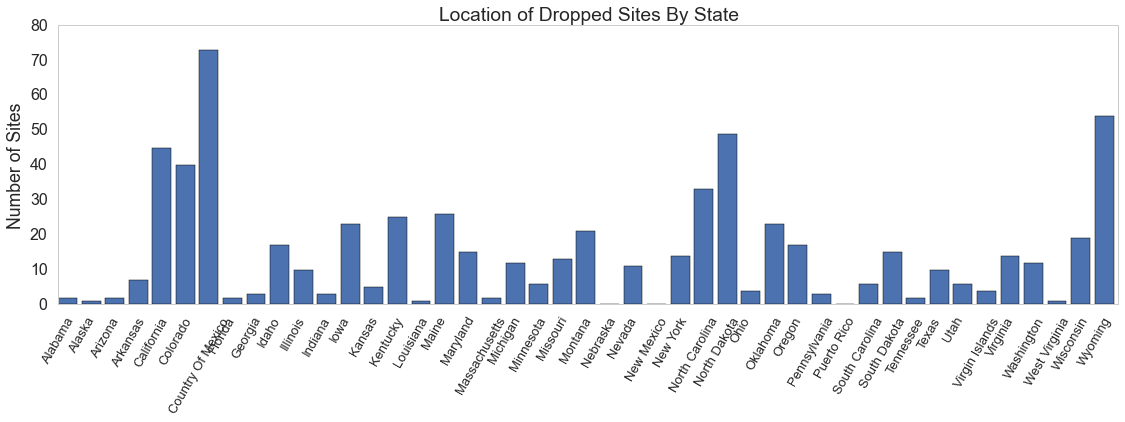

In [7]:
group = numDup.groupby('State Name')
f,ax = plt.subplots(figsize=(19,5))
ax.bar(range(len(group)),group.count()['Local Site Name'])
ax.set_xticks(range(len(group)))
ax.grid(False)
ax.set_xticklabels(group.count().index,rotation=60,size=13,ha='center')
ax.set_title('Location of Dropped Sites By State')
ax.set_ylabel('Number of Sites')
plt.show()

There are some states that have more dropped sites than others. There seems to be slight bias in the more rural areas -- this makes sense at CBSA assignments are for metropolitan and micropolitan areas. The state that loses the most sites is actually the Country of Mexico which we'd probably like to exclude anyway given that we are interested in the US.

####Collecting Demographics

We will proceed with just the sites that fall in a particular CBSA. This allows interpretation and data compiling a bit easier without a large loss of information.

Next we'd like to be able to pull population density information and other info in for these CBSA ids. This requires another data set from http://www.census.gov/population/metro/data/pop_data.html. This data is from 2010, but even though we're looking at 2014 weather/air quality data, it shouldn't have changed too dramatically in 4 years.

In [11]:
densityFile = pd.read_csv('tempdata/CBSA_density.csv')

In [12]:
#Removing top bad rows (just nonsense), removing bad columns, renaming columns
densityFile.drop(densityFile.index[[0,1,2,3,4,5,6,7]],inplace=True)
densityFile.drop(densityFile.columns[[3,6,8,10]],axis=1,inplace=True)
densityFile.columns=['id','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']

In [13]:
densityFile.head()

,id,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
8,10180,"Abilene, TX",Metropolitan Statistical Area,"165,252","2,743.5",60.2,"1,771.8"
9,10420,"Akron, OH",Metropolitan Statistical Area,"703,200",900.1,781.2,"2,412.8"
10,10500,"Albany, GA",Metropolitan Statistical Area,"157,308","1,932.6",81.4,922.7
11,10580,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,"870,716","2,811.6",309.7,"2,944.9"
12,10740,"Albuquerque, NM",Metropolitan Statistical Area,"887,077","9,282.5",95.6,"3,518.6"


This next file has the latitude and longitude data we'll want to use for each region. We need to merge this all together in case we need to do mapping later.

In [14]:
latlong = pd.read_csv('tempdata/CBSA_Chapter1PrinCities.csv')

This file has a lot of problems in the way information is provided. We want info for just the individual regions but there are a lot of NaNs. This is because only the primary city of a region gets the label. So we need to clean that up a bit. 

In [15]:
#Removing top bad rows, removing bad columns, renaming columns
latlong.drop(latlong.index[[0,1,2,3,4]],inplace=True)
latlong.drop(latlong.columns[[1,4]],axis=1,inplace=True)
latlong.columns=['id','name','pop2010','latitude','longitude']

In [16]:
#Get latitude and longitude for each id
group = latlong.groupby('id')
#Get rid of all the NaNs
#Help from 
#http://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-of-certain-column-is-nan
newdf=group.max()
newdf = newdf[pd.notnull(newdf['latitude'])]
#Weird anomaly
newdf.drop(newdf.index[6],inplace=True)

In [17]:
newdf['id']=newdf.index
newdf.head()

,name,pop2010,latitude,longitude,id
id,,,,,
10180,"Abilene, TX Metro Area","165,252",32.4519790,-99.7327870,10180
10420,"Akron, OH Metro Area","703,200",41.0805750,-81.5180690,10420
10500,"Albany, GA Metro Area","77,434",31.5783550,-84.1525160,10500
10580,Troy city,"97,856",42.6517310,-73.7551670,10580
10740,"Albuquerque, NM Metro Area","887,077",35.0879680,-106.6504030,10740


For merging purposes, we need to get a unique mapper between all the files. It's easiest to link all the different names of the CBSA's with a particular numerical ID that exists in these last two files. We spend a bit of time here setting those up to save work later.

In [19]:
#Make a mapper to get numerical id for CBSA
idmapper = {}
for id, name in zip(densityFile.id,densityFile.name):
    idmapper[name]=id

In [20]:
#Set up the dictionary base
#The first entry in uniqueCBSA is NaN so we want
#to remove that
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Bend, OR",13460


Some CBSA's didn't map to a particular numerical ID. This is because the CBSA namings have changed over time. It's painful, but probably easiest, to manually fix these 23 issues.

In [21]:
#Deal with missing numerical labels case-by-case...
#Painful, but doable
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))
a

Number of cities without numerical ID match: 23


,name,id
17,"Wenatchee, WA",None
28,"Bakersfield, CA",None
39,"San Antonio, TX",None
51,"Portland-Vancouver-Beaverton, OR-WA",None
68,"Myrtle Beach-Conway-North Myrtle Beach, SC",None
115,"Bradenton-Sarasota-Venice, FL",None
118,"Madera, CA",None
122,"Atlantic City, NJ",None
149,"Weirton-Steubenville, WV-OH",None
155,"Chicago-Naperville-Joliet, IL-IN-WI",None


In [22]:
#This dictionary has the name in myFrame and then the new name we need to use to map to the numerical ID as the value
badmatch = {'Wenatchee, WA':'Wenatchee-East Wenatchee, WA','San Antonio, TX':'San Antonio-New Braunfels, TX',
           'Portland-Vancouver-Beaverton, OR-WA':'Portland-Vancouver-Hillsboro, OR-WA','Bradenton-Sarasota-Venice, FL':'North Port-Bradenton-Sarasota, FL',
           'Madera, CA':'Madera-Chowchilla, CA','Atlantic City, NJ':'Atlantic City-Hammonton, NJ','Weirton-Steubenville, WV-OH':'Steubenville-Weirton, OH-WV',
           'Chicago-Naperville-Joliet, IL-IN-WI':'Chicago-Joliet-Naperville, IL-IN-WI','Bakersfield, CA':'Bakersfield-Delano, CA',
           'Durham, NC':'Durham-Chapel Hill, NC','Mayaguez, PR':'Mayag\xfcez, PR','Kennewick-Richland-Pasco, WA':'Kennewick-Pasco-Richland, WA',
           'Canon City, CO':'Ca\xf1on City, CO','Lakeland, FL':'Lakeland-Winter Haven, FL','Orlando-Kissimmee, FL':'Orlando-Kissimmee-Sanford, FL',
           'Phoenix-Mesa-Scottsdale, AZ':'Phoenix-Mesa-Glendale, AZ','Nashville-Davidson-Murfreesboro-Franklin, TN':'Nashville-Davidson--Murfreesboro--Franklin, TN',
           'Charlotte-Gastonia-Concord, NC-SC':'Charlotte-Gastonia-Rock Hill, NC-SC','Washington Court House, OH, AR':'Washington Court House, OH',
           'Panama City-Lynn Haven, FL':'Panama City-Lynn Haven-Panama City Beach, FL','Fort Walton Beach-Crestview-Destin, FL':'Crestview-Fort Walton Beach-Destin, FL',
           'Austin-Round Rock, TX':'Austin-Round Rock-San Marcos, TX','Charleston-North Charleston, SC':'Charleston-North Charleston-Summerville, SC',
           'Denver-Aurora, CO':'Denver-Aurora-Broomfield, CO','Myrtle Beach-Conway-North Myrtle Beach, SC':'Myrtle Beach-North Myrtle Beach-Conway, SC'}

In [23]:
#We need to reverse this dictionary for use later as well
reverse_bad = {v: k for k, v in badmatch.items()}
for id, name in zip(densityFile.id,densityFile.name):
    if name in badmatch.values():
        idmapper[reverse_bad[name]]=id

In [24]:
#Make a copy of the mapper to use in the rest of the data
idmapper2 = idmapper.copy()

In [25]:
#Rerun the mapping afresh
myFrame = pd.DataFrame({'name':list(uniqueCBSA)[1:]})
#Add numerical label 
myFrame['id']=myFrame['name'].map(idmapper2.get)
myFrame.head()

,name,id
0,"Kahului-Wailuku, HI",27980
1,"Rapid City, SD",39660
2,"Seymour, IN",42980
3,"Fort Wayne, IN",23060
4,"Bend, OR",13460


In [26]:
#Check the dataframe
a = myFrame[pd.isnull(myFrame['id'])]
print "Number of cities without numerical ID match: "+str(len(a))

Number of cities without numerical ID match: 0


We now have all our cities mapped to numerical IDs. Great! Now comes time to start merging things together. After these next few cells we are left with a dataframe with some information about each of the CBSAs.

In [27]:
myFrame.merge(newdf,on='id',how='left').head()

,name_x,id,name_y,pop2010,latitude,longitude
0,"Kahului-Wailuku, HI",27980,NaN,NaN,NaN,NaN
1,"Rapid City, SD",39660,"Rapid City, SD Metro Area","67,956",44.0830460,-103.2262970
2,"Seymour, IN",42980,NaN,NaN,NaN,NaN
3,"Fort Wayne, IN",23060,"Fort Wayne, IN Metro Area","416,257",41.0805560,-85.1391380
4,"Bend, OR",13460,"Bend, OR Metro Area","76,639",44.0573050,-121.3158290


In [28]:
#Add latitude longitude
intermediate = myFrame.merge(newdf,on='id',how='left')
intermediate.drop(intermediate.columns[2],axis=1,inplace=True)

In [29]:
#Add population density
DemoFrame = intermediate.merge(densityFile,on='id',how='left')
DemoFrame.drop(DemoFrame.columns[[0,2]],axis=1,inplace=True)
DemoFrame.columns=['id','latitude','longitude','name','MetArea','pop2010','landarea','popdense2010','pop_weight2010']
#Fix values that have commas like 1,049 and 1,170.8 so we can use them as floats later
a = [str(x) for x in list(DemoFrame['popdense2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['popdense2010']=b
a = [str(x) for x in list(DemoFrame['pop_weight2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['pop_weight2010']=b
a = [str(x) for x in list(DemoFrame['landarea'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['landarea']=b
a = [str(x) for x in list(DemoFrame['pop2010'].values)]
b = [float(x.replace(",","")) for x in a]
DemoFrame['pop2010']=b
#View the frame
DemoFrame.head()

,id,latitude,longitude,name,MetArea,pop2010,landarea,popdense2010,pop_weight2010
0,27980,NaN,NaN,"Kahului-Wailuku, HI",Micropolitan Statistical Area,154834,1161.5,133.3,2310.8
1,39660,44.0830460,-103.2262970,"Rapid City, SD",Metropolitan Statistical Area,126382,6247.5,20.2,1170.8
2,42980,NaN,NaN,"Seymour, IN",Micropolitan Statistical Area,42376,509.3,83.2,784.2
3,23060,41.0805560,-85.1391380,"Fort Wayne, IN",Metropolitan Statistical Area,416257,1361.0,305.9,1964.2
4,13460,44.0573050,-121.3158290,"Bend, OR",Metropolitan Statistical Area,157733,3018.2,52.3,1154.6


####Collecting Transit Data

Now we need to compile the traffic data to use. This comes from an excel file that is quite large -- we need to manipulate to collect the relevant pieces of information

In [30]:
#Load traffic excel file
trafDat = pd.read_excel('tempdata/census_commute_2009_2013.xlsx')

In [31]:
#Drop first several rows of excess info
trafDat.drop(trafDat.index[[0,1,2,3,4,5,6,106181,106182,106183,106184,106185]],inplace=True)

In [32]:
#Drop excess columns
trafDat.drop(trafDat.columns[[0,1,2,3,4,5,6,7]],axis=1,inplace=True)

In [33]:
#Rename remaing columns appropriately
trafDat.columns=['State','County','id','CBSA Name','Travel Mode','NumComm','MOE']

In [34]:
#Group by the id (numerical CBSA id) and the travel mode
#Get sum of people commuting into each CBSA by each travel
#mode
group = trafDat.groupby(['id','Travel Mode'])
a = pd.DataFrame(group.sum()['NumComm'])
trafDatClean = a.reset_index()

In [35]:
trafDatClean.head()

,id,Travel Mode,NumComm
0,10180,"Car, truck, or van: Carpooled",8489
1,10180,"Car, truck, or van: Drove alone",57771
2,10180,Other travel mode,5130
3,10180,Public transportation,450
4,10260,"Car, truck, or van: Carpooled",263


In [36]:
uniqueTraf = trafDatClean['id'].unique()

In [37]:
#Get ids that are in the demo and air data
airDatID = []
for i in idmapper2.values():
    if str(i) == 'nan':
        continue
    else:
        airDatID.append(int(i))
        
goods = []
bads = []
for i in uniqueTraf:
    if i in airDatID:
        goods.append(i)
    else:
        bads.append(i)

In [38]:
print 'Number of Traffic Locations in Other Data: '+str(len(goods))
print 'Number of Traffic Locations NOT in Other Data: '+str(len(bads))

Number of Traffic Locations in Other Data: 384
Number of Traffic Locations NOT in Other Data: 9


The vast majority of cities with traffic data also are found in the air quality data which is great! There are a few ids that are not in our air quality data. We can take a look at what those cities are here.

In [52]:
for i in bads:
    a = trafDat[trafDat['id']==i]
    print a['CBSA Name'].unique()

[u'Arecibo, PR']
[u'Bloomington, IL ']
[u'California-Lexington Park, MD ']
[u'Coco, PR']
[u'Lafayette-West Lafayette, IN ']
[u'Los Angeles-Long Beach-Anaheim, CA ']
[u'Santa Maria-Santa Barbara, CA ']
[u'Urban Honolulu, HI ']
[u'Weirton-Steubenville, WV-OH ']


There doesn't seem to be any systematic difference here so we will just assume we don't have air quality data for these cities, so they're not of interest because we can't make predictions. Therefore they will just be dropped.

The next code is a bit of cleaning to get a dataframe that we can merge with our other data. Right now we just have overall numbers of commuters into each region. We'd like to get fractional breakdowns of commuters by type so we calculate the below.

In [39]:
#Generate a dataframe of the traffic data for merging
#Specify the columns to be used
outDict = {'total_trans':[],'carpool':[],'alone':[],'other':[],'pt':[],'carpool_frac':[],
          'alone_frac':[],'other_frac':[],'pt_frac':[]}
#Keep track of the index
index = []

#Loop through all the cities in the traffic file
for i in trafDatClean['id'].unique():
    #Subset to the specific city
    a = trafDatClean[trafDatClean['id']==i]
    #Get the counts
    total = int(a['NumComm'].sum())
    carpool = int(a[a['Travel Mode']=='Car, truck, or van: Carpooled']['NumComm'])
    alone = int(a[a['Travel Mode']=='Car, truck, or van: Drove alone']['NumComm'])
    other = int(a[a['Travel Mode']=='Other travel mode']['NumComm'])
    pt = int(a[a['Travel Mode']=='Public transportation']['NumComm'])
    #Get the fractions
    carpool_frac = float(carpool)/float(total)
    alone_frac = float(alone)/float(total)
    other_frac = float(other)/float(total)
    pt_frac = float(pt)/float(total)
    #Append relevant information
    index.append(i)
    outDict['total_trans'].append(total)
    outDict['carpool'].append(carpool)
    outDict['alone'].append(alone)
    outDict['other'].append(other)
    outDict['pt'].append(pt)
    outDict['carpool_frac'].append(carpool_frac)
    outDict['alone_frac'].append(alone_frac)
    outDict['other_frac'].append(other_frac)
    outDict['pt_frac'].append(pt_frac)
#Return dataframe
trafDatCompiled = pd.DataFrame(outDict,index=index)
trafDatCompiled['id']=trafDatCompiled.index

####Merging Demographics, Air Quality, Weather, and Transit Data

What we need to do here is aggregate information across all these files -- traffic, demographics, weather, and air quality. The weather and air quality data is still stored *daily* information. So that's the first challenge. We will work with just the average daily readings to begin with (we could have looked at max readings, but that may not be as informative as an overall metric). Then we want to aggreate daily measurements at a location to average monthly readings. average seasonal readings, and average yearly readings. This may not be the *most* robust strategy, but it will hopefully give a good starting point to investiage trends.

In [40]:
#DOING SEASONAL AVERAGING FIRST
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','season'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','season'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','season'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means.drop(['month'],axis=1,inplace=True)

In [41]:
means['id']=means['CBSA Name'].map(idmapper2.get)

In [42]:
SeasonDat = means[means['id'].isin(myFrame['id'])]

In [43]:
SeasonDat.shape

(2105, 29)

In [44]:
print "# of Cities with Winter Data: "+str(SeasonDat[SeasonDat['season']=='Winter'].shape[0])
print "# of Cities with Summer Data: "+str(SeasonDat[SeasonDat['season']=='Summer'].shape[0])
print "# of Cities with Spring Data: "+str(SeasonDat[SeasonDat['season']=='Spring'].shape[0])
print "# of Cities with Fall Data: "+str(SeasonDat[SeasonDat['season']=='Fall'].shape[0])

# of Cities with Winter Data: 516
# of Cities with Summer Data: 529
# of Cities with Spring Data: 531
# of Cities with Fall Data: 529


In [45]:
#DOING MONTHLY AVERAGING SECOND
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name','month'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name','month'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name','month'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means['id']=means['CBSA Name'].map(idmapper2.get)
MonthDat = means[means['id'].isin(myFrame['id'])]
MonthDat.shape

(6239, 29)

In [46]:
print "# of Cities with January Data: "+str(MonthDat[MonthDat['month']==1].shape[0])
print "# of Cities with February Data: "+str(MonthDat[MonthDat['month']==2].shape[0])
print "# of Cities with March Data: "+str(MonthDat[MonthDat['month']==3].shape[0])
print "# of Cities with April Data: "+str(MonthDat[MonthDat['month']==4].shape[0])
print "# of Cities with May Data: "+str(MonthDat[MonthDat['month']==5].shape[0])
print "# of Cities with June Data: "+str(MonthDat[MonthDat['month']==6].shape[0])
print "# of Cities with July Data: "+str(MonthDat[MonthDat['month']==7].shape[0])
print "# of Cities with August Data: "+str(MonthDat[MonthDat['month']==8].shape[0])
print "# of Cities with September Data: "+str(MonthDat[MonthDat['month']==9].shape[0])
print "# of Cities with October Data: "+str(MonthDat[MonthDat['month']==10].shape[0])
print "# of Cities with November Data: "+str(MonthDat[MonthDat['month']==11].shape[0])
print "# of Cities with December Data: "+str(MonthDat[MonthDat['month']==12].shape[0])

# of Cities with January Data: 505
# of Cities with February Data: 508
# of Cities with March Data: 526
# of Cities with April Data: 529
# of Cities with May Data: 529
# of Cities with June Data: 529
# of Cities with July Data: 529
# of Cities with August Data: 529
# of Cities with September Data: 529
# of Cities with October Data: 523
# of Cities with November Data: 502
# of Cities with December Data: 501


In [47]:
#DOING YEARLY AVERAGING THIRD
fileList = [pm25_frmfem,pm25_nofrmfem,pm10,temp,press,rh,dp,wind,co,no2,ozone,so2]
fileName = ['PM25_FRMFEM','PM25_NOFRMFEM','PM10','TEMP','PRESS','RH','DP','WIND','CO','NO2','OZONE','SO2']
count = 0
for f,n in zip(fileList,fileName):
    if count == 0:
        group = f.groupby(['CBSA Name'])
        means = group.mean()
        means.drop(means.columns[[0,1,2,3,4,7,8,10,11,13,14]],axis=1,inplace=True)
        means.reset_index()
        means.reset_index(inplace=True)
        means.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
    else:
        group = f.groupby(['CBSA Name'])
        toAdd = group.mean()
        toAdd = pd.DataFrame(toAdd, columns=['Arithmetic Mean','AQI'])
        toAdd.reset_index()
        toAdd.reset_index(inplace=True)
        toAdd.rename(columns={ 'Arithmetic Mean' : n,'AQI' : 'AQI_'+n},inplace=True)
        means = pd.merge(means,toAdd.reset_index(),on=['CBSA Name'],how='outer').reset_index()
        means.drop(['level_0','index'],axis=1,inplace=True)
    count += 1
means['id']=means['CBSA Name'].map(idmapper2.get)
YearDat = means[means['id'].isin(myFrame['id'])]
YearDat.shape

(533, 28)

In [48]:
#Merge in demographic info
SeasonDat = SeasonDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')
MonthDat = MonthDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')
YearDat = YearDat.merge(DemoFrame[['id','MetArea','pop2010','landarea','popdense2010','pop_weight2010']],on='id',how='left')

In [49]:
trafDatCompiled.head()

,alone,alone_frac,carpool,carpool_frac,other,other_frac,pt,pt_frac,total_trans,id
10180,57771,0.804162,8489,0.118165,5130,0.071409,450,0.006264,71840,10180
10260,1988,0.759648,263,0.100497,359,0.137180,7,0.002675,2617,10260
10380,56397,0.835486,5157,0.076398,5625,0.083331,323,0.004785,67502,10380
10420,279452,0.862533,21925,0.067672,18393,0.056770,4220,0.013025,323990,10420
10500,46696,0.794907,7895,0.134397,3525,0.060006,628,0.010690,58744,10500


Now we have the weather and air quality data together in an individual file each. We next just need to merge in the demographic and traffic data and we'll be good to go!

In [51]:
#Covert ids to int for easier merging with traffic data
SeasonDat['id']=SeasonDat['id'].astype(int)
YearDat['id']=YearDat['id'].astype(int)
MonthDat['id']=MonthDat['id'].astype(int)

In [52]:
#Merge in traffic data
SeasonDat = SeasonDat.merge(trafDatCompiled,on='id',how='left')
MonthDat = MonthDat.merge(trafDatCompiled,on='id',how='left')
YearDat = YearDat.merge(trafDatCompiled,on='id',how='left')

In [53]:
#Remove a few nonsensical columns that are all NAs
MonthDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)
SeasonDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)
YearDat.drop(['AQI_TEMP','AQI_PRESS','AQI_RH','AQI_DP','AQI_WIND'],axis=1,inplace=True)

In [54]:
#Save the cleaned dataframe to file
MonthDat.to_csv("MonthDat.csv",index=False,na_rep='NA')
YearDat.to_csv("YearDat.csv",index=False,na_rep='NA')
SeasonDat.to_csv("SeasonDat.csv",index=False,na_rep='NA')

All these datasets have a straightforward labeling convention. The scheme is laid out below.

In [55]:
import collections
varlab={'CBSA Name':'Core-Based Statistical Area Name','Month/Season':'This respective variable will be in the Month or Season dataset indicating the month or year the data is from',
                'Latitude':'The average latitude of all sites in the CBSA for the given time period','Longitude':'The average longitude of all sites in the CBSA for a given time period',
                'PM25_FRMFEM':'Average level of particulate matter up to 2.5 micrometers based on Federal Reference Method or Federal Equivalent Method in given time period (Micrograms/cubic meter (LC))',
                'AQI_PM25_FRMFEM':'Average Air Quality Index of Particulate Matter up to 2.5 micrometers in given time period',
                'PM25_NOFRMFEM':'Average level of particulate matter up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method in given time period (Micrograms/cubic meter (LC))',
                'AQI_PM25_NOFRMFEM':'Average Air Quality Index of Particulate Matter of up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method',
                'PM10':'Average Particulate Matter up to 10 micrometers in given time period (Microgram/cubic meter (25 C))',
                'AQ_PM10':'Average Air Quality Index of Particulate Matter of up to 10 micrometers in given time period',
                'TEMP':'Average Temperature over time period (F)','PRESS':'Average Air Pressure over time period (Millibars)',
                'RH':'Average Relative Humidity over time period (percent  relative humidity)','DP':'Dewpoint over time period (F)',
                'WIND':'Average wind speed (Knots)','CO':'Average CO levels over time period (ppm)','AQI_CO':"Average Air Quality Index of CO over time period",
                'NO2':'Average NO2 levels over time period (ppb)','AQI_NO2':'Average Air Quality Index of NO2 over time period (ppb)',
                'OZONE':'Average ozone levels (O3) over time period (ppm)','AQI_OZONE':'Average Air Quality Index of Ozone over time period',
                'SO2':"Average SO2 levels over time period (ppb)",'AQI_SO2':'Average AQI of SO2 over time period',
                'id':'Numerical ID of Core-Based Statistical Area','MetArea':'An indicator of whether the site is a Metropolitan or Micropolitan Area',
                'pop2010':'The population size of the CBA in 2010','landarea':'The size of the CBSA (square miles)',
                'popdense2010':'The population density of CBSA in 2010','pop_weight2010':'Population weighted density in 2010 of CBSA',
       'alone':'Number of individuals commuting into this region alone daily - 2010','alone_frac':'Fraction of individuals commuting into this region alone daily - 2010',
       'carpool':'Number of individuals commuting into this region in carpool daily - 2010','carpool_frac':'Fraction of individuals commuting into this region in carpool daily - 2010',
       'other':'Number of individuals commuting into this region by bike, walk, or other daily - 2010','other_frac':'Fraction of individuals commuting into this region via bike, walk, or other daily - 2010',
       'pt':'Number of individuals commuting into this region via public transit daily - 2010','pt_frac':'Fraction of individuals commuting into this region via public transit daily - 2010',
       'total':'Total number of individuals commuting in the region daily - 2010'}
a = collections.OrderedDict(sorted(varlab.items()))
out = pd.DataFrame(a.items(),columns=['Variable Name','Definition'])
print "Codebook for datasets:"
out

Codebook for datasets:


,Variable Name,Definition
0,AQI_CO,Average Air Quality Index of CO over time period
1,AQI_NO2,Average Air Quality Index of NO2 over time period (ppb)
2,AQI_OZONE,Average Air Quality Index of Ozone over time period
3,AQI_PM25_FRMFEM,Average Air Quality Index of Particulate Matter up to 2.5 micrometers in given time period
4,AQI_PM25_NOFRMFEM,Average Air Quality Index of Particulate Matter of up to 2.5 micrometers NOT based on Federal Reference Method or Federal Equivalent Method
5,AQI_SO2,Average AQI of SO2 over time period
6,AQ_PM10,Average Air Quality Index of Particulate Matter of up to 10 micrometers in given time period
7,CBSA Name,Core-Based Statistical Area Name
8,CO,Average CO levels over time period (ppm)
9,DP,Dewpoint over time period (F)


###France Data

For validation, we'd like to work with French city data. These cities are likely fairly comparable to lots of the US climatically and is an equally developed country so population sizes and transit will be similarly. Additionally, we know that pollutant profiles seem somewhat comparable between European and US cities. There are other choices we could have made but it seems like a decent country to make a comparison to.

Now that we have our main data source of US air quality, weather, demographic, and transit data, we similarly want to create files for France metropolitan areas to validate our analysis on. We cannot get this information from the EPA or US Census Data so we need to spend some time collecting this from various sources. The next several steps will involve collecting and cleaning this data. We will start with just pooling the yearly data as this is in a easier to access format. Not all the formats and years are 100% comparable with the US data, but it seems pretty close in most measures. Additionally, some subjective decisions were made along the way, but we will explain our motivation when those are made.

####Get population density information

For dealing with the French Metropolitan area data, it's easiest to start with collecting demographic information. These metropolitan areas (called 'Aire urbaines') seems fairly comparable with the structure of the CBSA's we used with the US cities. We don't want to look explicity at cities as this will overlook differences in the sprawling areas that we've included with the US data.

The best place to start for this is the following site https://fr.wikipedia.org/wiki/Liste_des_aires_urbaines_de_France. This lists all Aire Urbaines in France. We will collect data from population in 2012 -- presumably this won't be terribly different from the 2010 data so this seems to be a reasonable assumption at this point.

In [368]:
#These will be needed to deal with scraping and
#working with unicode text
import re
from bs4 import BeautifulSoup
import requests
import unicodedata

In [329]:
#THIS CODE WAS TAKEN FROM http://effbot.org/zone/re-sub.htm#unescape-html
#Using this function to help deal with unicode trouble
def unescape(text):
    def fixup(m):
        text = m.group(0)
        if text[:2] == "&#":
            # character reference
            try:
                if text[:3] == "&#x":
                    return unichr(int(text[3:-1], 16))
                else:
                    return unichr(int(text[2:-1]))
            except ValueError:
                pass
        else:
            # named entity
            try:
                text = unichr(htmlentitydefs.name2codepoint[text[1:-1]])
            except KeyError:
                pass
        return text # leave as is
    return re.sub("&#?\w+;", fixup, text)

In [330]:
#Get the wikipedia page of all France Metropolitans
metros=requests.get('https://fr.wikipedia.org/wiki/Liste_des_aires_urbaines_de_France')

In [379]:
#Parse the table of Aire Urbaines
#Keep track of the 2012 population,
#the name, and the link to that Aire Urbaines'
#wiki page
soup = BeautifulSoup(metros.text, "html.parser")
if soup.find("table",attrs={"class": "wikitable sortable"}):
    rows = soup.find("table",attrs={"class": "wikitable sortable"}).find_all("td")
output = {}
output['name']=[]
output['population']=[]
output['link']=[]
nameList = range(2,1000,6)
popList = [x +1 for x in nameList]
areaList = [x+4 for x in nameList]
counter=0
#This goes through each row in the table and 
#cleans the text up (removing superscripts and commas)
for row in rows:
    counter+=1
    if counter in nameList:
        output['name'].append(row.text.replace('[',"").replace(']','').strip())
    if counter in popList:
        output['population'].append(int(unescape(row.text).replace(u'\xa0','').replace('+',"").replace(',','').replace('[6]','')))
for row in rows:
    if row.find_all("a"):
        url = [unicodedata.normalize("NFKD",x.get("href")).encode('ascii','ignore') for x in row.find_all("a")][0]
        if not re.search(r'cite',url):
            output['link'].append(url)

In [385]:
#Make a dictionary linking each area to their respective link
urbaines = {}
for i,j in zip(output['name'],output['link']):
    urbaines[i]=j

In [855]:
#Make a dictionary linking each are to their respective population size
popdict = {}
for i,j in zip(output['name'],output['population']):
    popdict[i]=j

This is where the challenge of parsing uniquely formatted wiki pages comes in. We need to get all the 'communes' (towns) in each of these urban areas so that we can map all our air quality stations to their respective urban areas. Generally in each wiki page there is a list of INSEE (National Institude of Statistics and Economic Studies) codes that refer to each individual town. We can cross reference those with the names of each of those towns later and then link this information to the air quality information through the common identifier of city name. So for here, we just want to get the name of all towns in a particular urban area.

We also record the area (km2) of each of these urban areas. We need this for calculating population density which we will do later on.

In [919]:
#This is the big code block
#Initiate 2 empty dictionaries, one to record the towns
#and the second to record the area of each of those towns
communes = {}
areaDict = {}
#Loop through each urban area and its link
for i,j in zip(urbaines.values(),urbaines.keys()):
    print i,j
    #Initiate empty lists to append to
    communes[j]=[]
    areaDict[j]=[]
    #Clear rows fo this new loop
    rows=[]
    #Get the wiki page information and parse the sortable wiki table
    #keeping track of the headers and the content of the rows
    city=requests.get('https://fr.wikipedia.org'+i)
    soup = BeautifulSoup(city.text, "html.parser")
    if soup.find("table",attrs={"class": "wikitable sortable"}):
        rows = soup.find("table",attrs={"class": "wikitable sortable"}).find_all("td")
    if soup.find("table",attrs={"class": "wikitable sortable"}):
        headOrder = soup.find("table",attrs={"class": "wikitable sortable"}).find_all("th")
    #Use an indexing system to keep track of the total columns, the column where 'area' occurs
    #and the column where INSEE code appears. These tables are not all laid out the same so
    #we need to use this system each time (# of columns and column order can change)
    indexCode = 0
    colIndex = None
    colIndex2 = None
    end = None
    #This goes through the headers and stores the column # of interest
    for h in headOrder:
        indexCode += 1
        match = re.search('Code',h.text)
        if match:
            colIndex=indexCode
        match2 = re.search('Superficie',h.text)
        if match2:
            colIndex2=indexCode
        else:
            match2 = re.search('S.',h.text)
            if match2:
                colIndex2=indexCode
    #This records the total number of columns
    end = indexCode
    indices = []
    indices2 = []
    #This is a weird exception
    if i == '/wiki/Aire_urbaine_de_Nantes':
        indices=range(0,4000,6)
        indices2=range(5,4000,6)
    else:
        if end == 6:
            indices=range(colIndex-1,4000,6)
            indices2=range(colIndex2-1,4000,6)
        elif end == 7:
            indices=range(colIndex-1,4000,7)
            indices2=range(colIndex2-1,4000,7)
        elif end == 8:
            indices=range(colIndex-1,4000,8)
            indices2=range(colIndex2-1,4000,8)
    #A second exception
    if i == '/wiki/Aire_urbaine_de_Chamb%C3%A9ry':
        indices=range(colIndex-1,4000,8)
        indices2=range(colIndex2-1,4000,8)

    #Here we extract the relevant information for each
    #row now that we know the indices of the relevant info
    #by parsing the header
    counter = -1
    for r in rows:
        counter+=1
        #Again, weird exception
        if i == '/wiki/Aire_urbaine_de_Nantes':
            #This is the insee code
            if counter in indices:
                if r.text:
                    try:
                        communes[j].append(r.text)
                    except:
                        continue 
            #This is the area in km2 -- it uses a , instead of . so
            #we need to change that
            elif counter in indices2:
                if r.text:
                    try:
                        areaDict[j].append(float(r.text.split(',')[0])+float(r.text.split(',')[1])/100)
                    except:
                        continue
                            
        else:
            #This is the insee code
            if counter in indices:
                if r.text:
                    try:
                        communes[j].append(r.text)
                    except:
                        continue
            #This is the area in km2 -- it uses a , instead of . so
            #we need to change that
            elif counter in indices2:
                if r.text:
                    try:
                        areaDict[j].append(float(r.text.split(',')[0])+float(r.text.split(',')[1])/100)
                    except:
                        continue
    #Make sure to wait a second in between calls
    time.sleep(1)

/wiki/Aire_urbaine_de_Cholet Cholet
/wiki/Aire_urbaine_de_Paris Paris
/wiki/Aire_urbaine_de_Montb%C3%A9liard Montbéliard
/wiki/Aire_urbaine_de_Bordeaux Bordeaux
/wiki/Aire_urbaine_de_Chamb%C3%A9ry Chambéry
/wiki/Aire_urbaine_de_Gen%C3%A8ve-Annemasse Genève - Annemasse5,3
/wiki/Aire_urbaine_de_Cayenne Cayenne (Guyane)
/wiki/Aire_urbaine_de_Roanne Roanne
/wiki/Aire_urbaine_de_Perpignan Perpignan
/wiki/Aire_urbaine_de_Caen Caen
/wiki/Aire_urbaine_de_Nantes Nantes
/wiki/Aire_urbaine_de_Saint-Denis Saint-Denis (La Réunion)
/wiki/Aire_urbaine_de_Chartres Chartres
/wiki/Aire_urbaine_de_Chalon-sur-Sa%C3%B4ne Chalon-sur-Saône
/wiki/Aire_urbaine_de_Mamoudzou Mamoudzou (Mayotte)
/wiki/Aire_urbaine_de_N%C3%AEmes Nîmes
/wiki/Aire_urbaine_de_Valenciennes Valenciennes3
/wiki/Aire_urbaine_de_Besan%C3%A7on Besançon
/wiki/Aire_urbaine_de_Saint-%C3%89tienne Saint-Étienne
/wiki/Aire_urbaine_de_Saint-Quentin Saint-Quentin
/wiki/Aire_urbaine_de_Niort Niort
/wiki/Aire_urbaine_de_Rouen Rouen
/wiki/Aire_urbain

This should leave us with 2 dictionaries, one containing all the INSEE codes of an urban area and the other containing all the areas of the towns in an urban area that we will have to sum up to get the total size of the urban area. There were a few urban areas that didn't get info, which we can see with below.

In [1559]:
for i in communes:
    if communes[i] == []:
        print i

Saint-Paul (La Réunion)
Saint-Pierre (La Réunion)


This is quite a small count (9 urban areas). We can manually obtain this data still. La Reunion is actually an island off Madagascar so we will ignore Saint-Paul and Saint-Pierre as they aren't really in France. There are actually a couple weird entries here (Paris and Saint-Nazaire) that don't have INSEE codes so we've just used the town names. There is actually another urban area(Nantes) that did this within the parsing. We have to be careful how we deal with that later on. Also, Paris has a ridiculous amount of towns included in its urban area so we should really make sure that's capturing what we want later on.

In [1583]:
communes[u'Cayenne (Guyane)']=['97302','97305','97307','97313','97309','97310']
communes[u'Le Mans']=['72001','72003','72004','72007','72008','72012','72023','72024','72026',
                      '72033','72045','72046','72047','72051','72053','72054','72058','72065',
                      '72066','72070','72072','72073','72075','72088','72089','72095','72096',
                      '72099','72101','72107','72111','72113','72119','72124','72126','72127',
                      '72129','72130','72131','72133','72135','72143','72146','72147','72150',
                      '72155','72157','72165','72166','72169','72174','72177','72181','72186',
                      '72187','72194','72195','72197','72196','72198','72200','72205','72241',
                      '72210','72213','72216','72217','72219','72224','72226','72230','72231',
                      '72237','72243','72247','72248','72249','72252','72253','72257','72260',
                      '72261','72268','72271','72275','72280','72287','72289','72290','72293',
                      '72297','72298','72299','72300','72301','72306','72310','72319','72320',
                      '72321','72325','72328','72329','72335','72338','72339','72340','72344',
                      '72345','72346','72348','72349','72350','72359','72360','72362','72367',
                      '72370','72376','72381','72382','72385','72386']
communes[u'Valence']=['07052','07055','07059','07070','07097','07102','07240','07281','07293','07316',
                      '07323','26004','26007','26024','26032','26037','26038','26042','26058','26064',
                      '26079','26081','26084','26100','26124','26170','26196','26197','26206','26208',
                      '26212','26224','26232','26250','26252','26271','26313','26358','26362','26382']
communes[u'Saint-Nazaire']=[u'Assérac',u'Batz-sur-Mer',u'Besné',u'Crossac',u'Donges',u'Drefféac',u'Férel',u'Guérande',
                            u'Herbignac',u'La Baule-Escoublac',u'La Chapelle-des-Marais',u'La Turballe',u'Le Croisic',
                            u'Le Pouliguen',u'Mesquer',u'Missillac',u'Montoir-de-Bretagne',u'Piriac-sur-Mer',u'Pontchâteau',
                            u'Pornichet',u'Saint-André-des-Eaux',u'Sainte-Anne-sur-Brivet',u'Sainte-Reine-de-Bretagne',
                            u'Saint-Joachim',u'Saint-Lyphard',u'Saint-Malo-de-Guersac',u'Saint-Molf',u'Saint-Nazaire',
                            u'Trignac']
communes[u'Rennes']=['35001','35002','35003','35007','35016','35017','35022','35023','35024','35026','35028','35030','35031',
                     '35032','35033','35035','35037','35039','35040','35041','35047','35048','35050','35051','35053','35054',
                     '35055','35057','35058','35059','35060','35065','35066','35067','35068','35069','35076','35079','35080',
                     '35081','35088','35089','35090','35094','35096','35099','35101','35107','35108','35110','35118','35120',
                     '35121','35123','35126','35127','35128','35130','35131','35133','35134','35135','35136','35139','35144',
                     '35146','35149','35152','35156','35166','35169','35173','35175','35177','35180','35187','35188','35189',
                     '35193','35195','35196','35197','35198','35203','35204','35206','35207','35208','35209','35210','35212',
                     '35216','35218','35220','35221','35227','35231','35233','35238','35240','35245','35250','35251','35254',
                     '35258','35262','35264','35265','35266','35274','35275','35276','35277','35278','35281','35283','35289',
                     '35295','35296','35305','35307','35312','35315','35318','35319','35320','35321','35322','35327','35331',
                     '35334','35337','35340','35343','35351','35352','35353','35355','35356','35363']
communes[u'Orl\xe9ans']=['45006','45008','45009','45011','41006','41008','45019','28019','45020','45024','45028','41017',
                         '45034','45043','45044','45046','45055','41027','45058','45059','45062','45067','45072','45074',
                         '45075','45081','45082','45089','45093','45095','45098','45099','41056','45100','45101','41058',
                         '45109','45111','45116','45118','28121','45123','45126','45130','45134','45142','45144','45146',
                         '41085','45147','45152','45153','45154','28190','45164','45166','45167','45168','45169','45171',
                         '45173','41105','45175','45179','41114','45182','45183','28212','41119','45188','28221','45193',
                         '45194','45196','45197','45200','45202','45203','45204','45214','45224','45226','45232','45234',
                         '45235','45241','41173','45248','28296','28303','41183','45261','45262','45264','45266','45269',
                         '45272','45273','45274','45282','45284','45285','45286','41219','45289','45290','45296','45298',
                         '45299','45300','45301','45302','45305','41244','45308','45309','41245','45311','45313','45314',
                         '45316','45317','28382','45324','45326','45327','45330','41264','45331','45333','45335','45337',
                         '45341','41285','45342','41289','45344','45346']
communes[u'Paris']=[u'Bézu-le-Guéry',u'Brumetz',u'Bussiares',u'La Celle-sous-Montmirail',u'Chézy-en-Orxois',u'Coupru',
                    u'Courchamps',u'Crouttes-sur-Marne',u'Dammard',u'Domptin',u'Gandelu',u'Hautevesnes',u'Largny-sur-Automne',
                    u'Marigny-en-Orxois',u'Monnes',u'Montigny-l\'Allier',u'Montreuil-aux-Lions',u'Passy-en-Valois',u'Pavant',
                    u'Priez',u'Saint-Gengoulph',u'Veuilly-la-Poterie',u'Viels-Maisons',u'Aigleville',u'Amécourt',u'Authevernes',
                    u'Bazincourt-sur-Epte',u'Bernouville',u'Berthenonville',u'Bézu-la-Forêt',u'Bézu-Saint-Éloi',u'Bois-le-Roi',
                    u'La Boissière',u'Bretagnolles',u'Breuilpont',u'Bus-Saint-Rémy',u'Cahaignes',u'Chaignes',
                    u'Château-sur-Epte',u'Chauvincourt-Provemont',u'Civières',u'Coudray',u'La Couture-Boussey',u'Croth',
                    u'Dampsmesnil',u'Dangu',u'Doudeauville-en-Vexin',u'Écos',u'Épieds',u'Ézy-sur-Eure',u'Farceaux',u'Fontenay',
                    u'Fourges',u'Fours-en-Vexin',u'Gadencourt',u'Gamaches-en-Vexin',u'Garennes-sur-Eure',u'Gisors',u'Guerny',
                    u'L\'Habit',u'Hacqueville',u'Hébécourt',u'Hécourt',u'Heudicourt',u'Ivry-la-Bataille',u'Lignerolles',
                    u'Longchamps',u'Mainneville',u'Marcilly-sur-Eure',u'Martagny',u'Merey',u'Mesnil-sous-Vienne',u'Mouettes',
                    u'Mouflaines',u'Mousseaux-Neuville',u'Neaufles-Saint-Martin',u'Neuilly',u'La Neuve-Grange',
                    u'Nojeon-en-Vexin',u'Noyers',u'Puchay',u'Richeville',u'Saint-Denis-le-Ferment',u'Saint-Laurent-des-Bois',
                    u'Sainte-Marie-de-Vatimesnil',u'Sancourt',u'Serez',u'Suzay',u'Les Thilliers-en-Vexin',u'Vesly',
                    u'Villegats',u'Villers-en-Vexin',u'Villiers-en-Désœuvre',u'Abondant',u'Anet',u'Ardelu',u'Aunay-sous-Auneau',
                    u'Auneau',u'Bailleau-Armenonville',u'Barmainville',u'Baudreville',u'Berchères-sur-Vesgre',
                    u'Béville-le-Comte',u'Bleury',u'Boncourt',u'Bouglainval',u'Le Boullay-Thierry',u'Boutigny-Prouais',
                    u'Bréchamps',u'Broué',u'Bû',u'Champagne',u'Champseru',u'La Chapelle-d\'Aunainville',
                    u'La Chapelle-Forainvilliers',u'Charpont',u'Chartainvilliers',u'Châtenay',u'Chaudon',u'La Chaussée-d\'Ivry',
                    u'Coulombs',u'Croisilles',u'Denonville',u'Droue-sur-Drouette',u'Écluzelles',u'Écrosnes',u'Épernon',
                    u'Faverolles',u'Gallardon',u'Garancières-en-Beauce',u'Gas',u'Germainville',u'Gilles',u'Gommerville',
                    u'Gouillons',u'Goussainville',u'Guainville',u'Le Gué-de-Longroi',u'Hanches',u'Havelu',u'Houx',
                    u'Intréville',u'Léthuin',u'Levainville',u'Levesville-la-Chenard',u'Lormaye',u'Louville-la-Chenard',
                    u'Maintenon',u'Maisons',u'Marchezais',u'Mérouville',u'Le Mesnil-Simon',u'Mévoisins',
                    u'Moinville-la-Jeulin',u'Mondonville-Saint-Jean',u'Morainville',u'Néron',u'Neuvy-en-Beauce',
                    u'Nogent-le-Roi',u'Oinville-sous-Auneau',u'Orlu',u'Ormoy',u'Ouarville',u'Ouerre',u'Oulins',u'Oysonville',
                    u'Pierres',u'Les Pinthières',u'Roinville',u'Rouvray-Saint-Denis',u'Rouvres',u'Saint-Laurent-la-Gâtine',
                    u'Saint-Léger-des-Aubées',u'Saint-Lubin-de-la-Haye',u'Saint-Lucien',u'Saint-Martin-de-Nigelles',
                    u'Saint-Ouen-Marchefroy',u'Saint-Piat',u'Saint-Symphorien-le-Château',u'Sainville',u'Santeuil',u'Saussay',
                    u'Senantes',u'Serazereux',u'Serville',u'Sorel-Moussel',u'Soulaires',u'Umpeau',u'Vierville',
                    u'Villemeux-sur-Eure',u'Villiers-le-Morhier',u'Voise',u'Yermenonville',u'Ymeray',u'Andonville',
                    u'Autruy-sur-Juine',u'Boisseaux',u'Desmonts',u'Erceville',u'Morville-en-Beauce',u'Orville',
                    u'Pannecières',u'Rouvres-Saint-Jean',u'Thignonville',u'Réveillon',u'Le Vézier',u'Villeneuve-la-Lionne',
                    u'Abbecourt',u'Acy-en-Multien',u'Amblainville',u'Andeville',u'Anserville',u'Antilly',u'Apremont',
                    u'Auger-Saint-Vincent',u'Aumont-en-Halatte',u'Auteuil',u'Autheuil-en-Valois',u'Avilly-Saint-Léonard',
                    u'Bachivillers',u'Bargny',u'Baron',u'Beaumont-les-Nonains',u'Belle-Église',u'Béthancourt-en-Valois',
                    u'Betz',u'Boissy-Fresnoy',u'Boissy-le-Bois',u'Bonneuil-en-Valois',u'Boran-sur-Oise',u'Borest',u'Bornel',
                    u'Boubiers',u'Bouconvillers',u'Bouillancy',u'Boullarre',u'Boursonne',u'Boury-en-Vexin',u'Boutencourt',
                    u'Brégy',u'Cauvigny',u'Chambly',u'Chambors',u'Chantilly',u'Creil',u'La Chapelle-en-Serval',
                    u'Chaumont-en-Vexin',u'Chavençon',u'Chèvreville',u'Corbeil-Cerf',u'Le Coudray-sur-Thelle',
                    u'Courcelles-lès-Gisors',u'Courteuil',u'Coye-la-Forêt',u'Crépy-en-Valois',u'Crouy-en-Thelle',
                    u'Cuvergnon',u'Delincourt',u'Le Déluge',u'Dieudonné',u'Duvy',u'Éméville',u'Énencourt-Léage',
                    u'Énencourt-le-Sec',u'Éragny-sur-Epte',u'Ercuis',u'Ermenonville',u'Esches',u'Étavigny',u'Ève',
                    u'Fay-les-Étangs',u'Feigneux',u'Flavacourt',u'Fleury',u'Fontaine-Chaalis',u'Fosseuse',u'Foulangues',
                    u'Fresneaux-Montchevreuil',u'Fresne-Léguillon',u'Fresnoy-en-Thelle',u'Fresnoy-la-Rivière',
                    u'Fresnoy-le-Luat',u'Gilocourt',u'Glaignes',u'Gondreville',u'Gouvieux',u'Hadancourt-le-Haut-Clocher',
                    u'Hardivillers-en-Vexin',u'Hénonville',u'Hodenc-l\'Évêque',u'La Houssoye',u'Ivors',u'Ivry-le-Temple',
                    u'Jaméricourt',u'Jouy-sous-Thelle',u'Laboissière-en-Thelle',u'Labosse',u'Lachapelle-Saint-Pierre',
                    u'Lagny-le-Sec',u'Lalande-en-Son',u'Lamorlaye',u'Lattainville',u'Lavilletertre',u'Lévignen',
                    u'Liancourt-Saint-Pierre',u'Lierville',u'Loconville',u'Lormaison',u'Mareuil-sur-Ourcq',u'Marolles',
                    u'Méru',u'Le Mesnil-en-Thelle',u'Le Mesnil-Théribus',u'Monneville',u'Montagny-en-Vexin',
                    u'Montagny-Sainte-Félicité',u'Montherlant',u'Montjavoult',u'Montlognon',u'Monts',u'Morangles',u'Morienval',
                    u'Mortefontaine',u'Mortefontaine-en-Thelle',u'Nanteuil-le-Haudouin',u'Neufchelles',u'Neuilly-en-Thelle',
                    u'Neuville-Bosc',u'La Neuville-d\'Aumont',u'La Neuville-Garnier',u'Nogent-sur-Oise',u'Noailles',u'Novillers',
                    u'Ognes',u'Ormoy-Villers',u'Orrouy',u'Orry-la-Ville',u'Parnes',u'Péroy-les-Gombries',u'Plailly',
                    u'Le Plessis-Belleville',u'Ponchon',u'Pontarmé',u'Porcheux',u'Pouilly',u'Puiseux-en-Bray',
                    u'Puiseux-le-Hauberger',u'Réez-Fosse-Martin',u'Reilly',u'Ressons-l\'Abbaye',u'Rocquemont',u'Rosières',
                    u'Rosoy-en-Multien',u'Rouville',u'Rouvres-en-Multien',u'Russy-Bémont',u'Saint-Crépin-Ibouvillers',
                    u'Sainte-Geneviève',u'Saint-Pierre-es-Champs',u'Saint-Sulpice',u'Senots',u'Serans',u'Sérifontaine',
                    u'Séry-Magneval',u'Silly-le-Long',u'Silly-Tillard',u'Talmontiers',u'Thibivillers',u'Thiers-sur-Thève',
                    u'Thury-en-Valois',u'Tourly',u'Trie-Château',u'Trie-la-Ville',u'Trumilly',u'Ully-Saint-Georges',
                    u'Valdampierre',u'Varinfroy',u'Vauciennes',u'Vaudancourt',u'Le Vaumain',u'Vaumoise',u'Le Vauroux',
                    u'Ver-sur-Launette',u'Versigny',u'Vez',u'Villeneuve-les-Sablons',u'La Villeneuve-sous-Thury',
                    u'Villers-Saint-Genest',u'Villers-sur-Trie',u'Villotran',u'Vineuil-Saint-Firmin',u'Achères-la-Forêt',
                    u'Amillis',u'Amponville',u'Andrezel',u'Annet-sur-Marne',u'Arbonne-la-Forêt',u'Argentières',
                    u'Armentières-en-Brie',u'Aubepierre-Ozouer-le-Repos',u'Augers-en-Brie',u'Aulnoy',u'Avon',
                    u'Bailly-Romainvilliers',u'Balloy',u'Bannost-Villegagnon',u'Barbizon',u'Barcy',u'Bassevelle',
                    u'Beautheil',u'Beauvoir',u'Bellot',u'Bernay-Vilbert',u'Beton-Bazoches',u'Bezalles',u'Blandy',u'Boisdon',
                    u'Bois-le-Roi',u'Boissettes',u'Boissise-la-Bertrand',u'Boissise-le-Roi',u'Boissy-aux-Cailles',
                    u'Boissy-le-Châtel',u'Boitron',u'Bombon',u'Boulancourt',u'Bouleurs',u'Bourron-Marlotte',u'Boutigny',
                    u'Bréau',u'Brie-Comte-Robert',u'La Brosse-Montceaux',u'Brou-sur-Chantereine',u'Burcy',u'Bussières',
                    u'Bussy-Saint-Georges',u'Bussy-Saint-Martin',u'Carnetin',u'La Celle-sur-Morin',u'Cély-en-Bière',u'Cerneux',
                    u'Cesson',u'Cessoy-en-Montois',u'Chailly-en-Bière',u'Chailly-en-Brie',u'Chalifert',u'Chambry',u'Chamigny',
                    u'Champagne-sur-Seine',u'Champcenest',u'Champdeuil',u'Champeaux',u'Champs-sur-Marne',u'Changis-sur-Marne',
                    u'Chanteloup-en-Brie',u'La Chapelle-Gauthier',u'La Chapelle-Iger',u'La Chapelle-la-Reine',
                    u'La Chapelle-Rablais',u'La Chapelle-Saint-Sulpice',u'Les Chapelles-Bourbon',u'La Chapelle-Moutils',
                    u'Charmentray',u'Charny',u'Chartrettes',u'Chartronges',u'Châteaubleau',u'Le Châtelet-en-Brie',
                    u'Châtenay-sur-Seine',u'Châtillon-la-Borde',u'Châtres',u'Chauffry',u'Chaumes-en-Brie',u'Chelles',
                    u'Chenoise',u'Chessy',u'Chevru',u'Chevry-Cossigny',u'Choisy-en-Brie',u'Citry',u'Claye-Souilly',
                    u'Clos-Fontaine',u'Cocherel',u'Collégien',u'Combs-la-Ville',u'Compans',u'Conches-sur-Gondoire',
                    u'Condé-Sainte-Libiaire',u'Congis-sur-Thérouanne',u'Coubert',u'Couilly-Pont-aux-Dames',
                    u'Coulombs-en-Valois',u'Coulommes',u'Coulommiers',u'Coupvray',u'Courcelles-en-Bassée',u'Courpalay',
                    u'Courquetaine',u'Courtacon',u'Courtomer',u'Courtry',u'Coutençon',u'Coutevroult',u'Crécy-la-Chapelle',
                    u'Crégy-lès-Meaux',u'Crèvecœur-en-Brie',u'Crisenoy',u'Croissy-Beaubourg',u'La Croix-en-Brie',
                    u'Crouy-sur-Ourcq',u'Cucharmoy',u'Cuisy',u'Dagny',u'Dammarie-lès-Lys',u'Dammartin-en-Goële',
                    u'Dammartin-sur-Tigeaux',u'Dampmart',u'Dhuisy',u'Donnemarie-Dontilly',u'Dormelles',u'Doue',
                    u'Douy-la-Ramée',u'Échouboulains',u'Les Écrennes',u'Écuelles',u'Égligny',u'Émerainville',u'Épisy',
                    u'Esbly',u'Étrépilly',u'Évry-Grégy-sur-Yerre',u'Faremoutiers',u'Favières',u'Féricy',u'Férolles-Attilly',
                    u'Ferrières-en-Brie',u'La Ferté-Gaucher',u'La Ferté-sous-Jouarre',u'Flagy',u'Fleury-en-Bière',
                    u'Fontainebleau',u'Fontaine-le-Port',u'Fontains',u'Fontenailles',u'Fontenay-Trésigny',u'Forfry',u'Fouju',
                    u'Fresnes-sur-Marne',u'Frétoy',u'Fromont',u'Fublaines',u'Garentreville',u'Gastins',u'La Genevraye',
                    u'Germigny-l\'Évêque',u'Germigny-sous-Coulombs',u'Gesvres-le-Chapitre',u'Giremoutiers',u'Gouvernes',
                    u'La Grande-Paroisse',u'Grandpuits-Bailly-Carrois',u'Gravon',u'Gressy',u'Gretz-Armainvilliers',
                    u'Grez-sur-Loing',u'Grisy-Suisnes',u'Guérard',u'Guercheville',u'Guermantes',u'Guignes',u'Gurcy-le-Châtel',
                    u'Hautefeuille',u'La Haute-Maison',u'Héricy',u'Hondevilliers',u'La Houssaye-en-Brie',u'Isles-les-Meldeuses',
                    u'Isles-lès-Villenoy',u'Iverny',u'Jablines',u'Jaignes',u'Jossigny',u'Jouarre',u'Jouy-le-Châtel',
                    u'Jouy-sur-Morin',u'Juilly',u'Lagny-sur-Marne',u'Larchant',u'Laval-en-Brie',u'Lescherolles',u'Lesches',
                    u'Lésigny',u'Leudon-en-Brie',u'Lieusaint',u'Limoges-Fourches',u'Lissy',u'Liverdy-en-Brie',
                    u'Livry-sur-Seine',u'Lizines',u'Lizy-sur-Ourcq',u'Lognes',u'Longperrier',u'Luisetaines',
                    u'Lumigny-Nesles-Ormeaux',u'Luzancy',u'Machault',u'Magny-le-Hongre',u'Maincy',u'Maisoncelles-en-Brie',
                    u'Maison-Rouge',u'Marchémoret',u'Marcilly',u'Les Marêts',u'Mareuil-lès-Meaux',u'Marles-en-Brie',
                    u'Marolles-en-Brie',u'Mary-sur-Marne',u'Mauperthuis',u'Mauregard',u'May-en-Multien',u'Meaux',u'Mée-sur-Seine',
                    u'Meigneux',u'Meilleray',u'Melun',u'Méry-sur-Marne',u'Le Mesnil-Amelot',u'Messy',u'Misy-sur-Yonne',
                    u'Mitry-Mory',u'Moisenay',u'Moissy-Cramayel',u'Mons-en-Montois',u'Montarlot',u'Montceaux-lès-Meaux',
                    u'Montceaux-lès-Provins',u'Montcourt-Fromonville',u'Montdauphin',u'Montereau-sur-le-Jard',u'Montévrain',
                    u'Montgé-en-Goële',u'Monthyon',u'Montigny-Lencoup',u'Montigny-sur-Loing',u'Montmachoux',u'Montolivet',
                    u'Montry',u'Moret-sur-Loing',u'Mormant',u'Mortcerf',u'Mouroux',u'Moussy-le-Neuf',u'Moussy-le-Vieux',u'Nandy',
                    u'Nangis',u'Nanteuil-lès-Meaux',u'Nanteuil-sur-Marne',u'Nantouillet',u'Chauconin-Neufmontiers',
                    u'Neufmoutiers-en-Brie',u'Noisiel',u'Noisy-Rudignon',u'Noisy-sur-École',u'Nonville',u'Ocquerre',u'Oissery',
                    u'Orly-sur-Morin',u'Othis',u'Ozoir-la-Ferrière',u'Ozouer-le-Voulgis',u'Pamfou',u'Paroy',u'Pécy',u'Penchard',
                    u'Perthes',u'Pézarches',u'Pierre-Levée',u'Pin',u'Le Plessis-aux-Bois',u'Le Plessis-Feu-Aussoux',
                    u'Le Plessis-l\'Évêque',u'Le Plessis-Placy',u'Poincy',u'Pommeuse',u'Pomponne',u'Pontault-Combault',u'Pontcarré',
                    u'Précy-sur-Marne',u'Presles-en-Brie',u'Pringy',u'Puisieux',u'Quiers',u'Quincy-Voisins',u'Rampillon',u'Réau',
                    u'Rebais',u'Recloses',u'Reuil-en-Brie',u'La Rochette',u'Roissy-en-Brie',u'Rouvres',u'Rozay-en-Brie',u'Rubelles',
                    u'Rumont',u'Rupéreux',u'Saâcy-sur-Marne',u'Sablonnières',u'Saint-Ange-le-Viel',u'Saint-Augustin',u'Sainte-Aulde',
                    u'Saint-Barthélemy',u'Saint-Cyr-sur-Morin',u'Saint-Denis-lès-Rebais',u'Saint-Fargeau-Ponthierry',u'Saint-Fiacre',
                    u'Saint-Germain-Laxis',u'Saint-Germain-sous-Doue',u'Saint-Germain-sur-École',u'Saint-Germain-sur-Morin',
                    u'Saint-Jean-les-Deux-Jumeaux',u'Saint-Just-en-Brie',u'Saint-Léger',u'Saint-Mammès',u'Saint-Mard',
                    u'Saint-Mars-Vieux-Maisons',u'Saint-Martin-des-Champs',u'Saint-Martin-du-Boschet',u'Saint-Martin-en-Bière',
                    u'Saint-Méry',u'Saint-Mesmes',u'Saint-Ouen-en-Brie',u'Saint-Ouen-sur-Morin',u'Saint-Pathus',
                    u'Saint-Rémy-la-Vanne',u'Saints',u'Saint-Sauveur-lès-Bray',u'Saint-Sauveur-sur-École',u'Saint-Siméon',
                    u'Saint-Soupplets',u'Saint-Thibault-des-Vignes',u'Salins',u'Sammeron',u'Samois-sur-Seine',u'Samoreau',
                    u'Sancy',u'Sancy-lès-Provins',u'Savigny-le-Temple',u'Savins',u'Seine-Port',u'Sept-Sorts',u'Serris',u'Servon',
                    u'Signy-Signets',u'Sigy',u'Sivry-Courtry',u'Sognolles-en-Montois',u'Soignolles-en-Brie',u'Solers',u'Tancrou',
                    u'Thénisy',u'Thieux',u'Thomery',u'Thorigny-sur-Marne',u'Thoury-Férottes',u'Tigeaux',u'Torcy',u'Touquin',
                    u'Tournan-en-Brie',u'Tousson',u'La Trétoire',u'Trilbardou',u'Trilport',u'Trocy-en-Multien',u'Ury',
                    u'Ussy-sur-Marne',u'Vaires-sur-Marne',u'Valence-en-Brie',u'Vanvillé',u'Varreddes',u'Vaucourtois',u'Le Vaudoué',
                    u'Vaudoy-en-Brie',u'Vaux-le-Pénil',u'Vendrest',u'Veneux-les-Sablons',u'Verdelot',u'Verneuil-l\'Étang',
                    u'Vernou-la-Celle-sur-Seine',u'Vert-Saint-Denis',u'Vieux-Champagne',u'Vignely',u'Villecerf',u'Villemaréchal',
                    u'Villemareuil',u'Villemer',u'Villeneuve-le-Comte',u'Villeneuve-les-Bordes',u'Villeneuve-Saint-Denis',
                    u'Villeneuve-sous-Dammartin',u'Villeneuve-sur-Bellot',u'Villenoy',u'Villeparisis',u'Villeroy',
                    u'Ville-Saint-Jacques',u'Villevaudé',u'Villiers-en-Bière',u'Villiers-sous-Grez',u'Villiers-sur-Morin',
                    u'Vimpelles',u'Vinantes',u'Vincy-Manœuvre',u'Voinsles',u'Voisenon',u'Voulangis',u'Vulaines-sur-Seine',u'Yèbles']

Now we can load the source of INSEE codes (found at http://www.insee.fr/fr/methodes/nomenclatures/cog/telechargement.asp) which we can then use to map town names.

In [1584]:
communeID = pd.read_csv('tempdata/france2015.txt',sep='\t')

In [1585]:
#We have to use this particular data file to create a the unique
#codes that map the INSEE codes above. This is a combination of 
#the COM and DEP columns. We also have to include 0's appropriately
#to get the right 5-digit codes which is done here
#We store that to COM2 for now
COM2 = []
for i,j in zip(communeID['COM'],communeID['DEP']):
    if (len(str(i))==1) and (len(str(j))==2):
        COM2.append('00'+str(i))
    elif (len(str(i))==2) and (len(str(j))==2):
        COM2.append('0'+str(i))
    elif (len(str(i))==1) and (len(str(j))==3):
        COM2.append('0'+str(i))
    else:
        COM2.append(str(i))

In [1586]:
#Now we add the COM2 column into our dataframe
communeID['COM2']=COM2

In [1587]:
#This converts the value to a string (we already converted
#COM to a string above)
communeID['DEP'] = communeID['DEP'].astype(str)

In [1588]:
#Now we make the column id which contains the unique codes
communeID['id']=communeID['DEP']+communeID['COM2']

In [1589]:
#We make a mapper to map the 5-digit code to
#the town name stored in NCC
communeID_dict = {}
for i,j in zip(communeID['id'],communeID['NCC']):
    communeID_dict[str(i)]=j

In [1590]:
#We make this special dictionary to deal with the few
#cases where we have names and not 5-digit codes
specialID_dict = {}
for i,j in zip(communeID['NCCENR'],communeID['NCC']):
    specialID_dict[i]=j

In [1690]:
#This makes our city names instead of 5-digit codes
#for each of the urban areas
communes2 = {}
for c in communes:
    #One off case with some weirdness
    if c == u'Gen\xe8ve - Annemasse5,3':
        communes2[u'Gen\xe8ve - Annemasse'] = []
        for i in communes[c]:
            if len(str(i))==4:
                communes2[u'Gen\xe8ve - Annemasse'].append(communeID_dict[str(0)+str(i)])
            elif len(str(i))==2:
                continue
            else:
                try:
                    communes2[u'Gen\xe8ve - Annemasse'].append(communeID_dict[str(i)])
                except:
                    pass
    #Deal with text urban areas, tons of weird exceptions
    #because of accents and other slight difference. We've
    #captured the vast majority with this code
    elif c in [u'Nantes',u'Paris',u'Saint-Nazaire']:
        communes2[c] = []
        for i in communes[c]:
            if i == 'Grandchamp-des-Fontaines':
                i='Grandchamps-des-Fontaines'
                communes2[c].append(specialID_dict[i])
            elif i == u'B\xe9zu-la-For\xeat':
                i='B\xe9zu-la-For\xeat'
                communes2[c].append(specialID_dict[i])
            elif i == u'Villiers-en-D\xe9s\u0153uvre':
                i='Villiers-en-D\xe9s\x9cuvre'
                communes2[c].append(specialID_dict[i])
            elif i == u'B\xfb':
                i='B\xfb'
                communes2[c].append(specialID_dict[i])
            elif i == u'C\xe9ly-en-Bi\xe8re':
                i='Chailly-en-Bi\xe8re'
                communes2[c].append(specialID_dict[i])
            elif i == u'Cr\xe8vec\u0153ur-en-Brie':
                i='Cr\xe8vec\x9cur-en-Brie'
                communes2[c].append(specialID_dict[i])
            elif i == u'Dammarie-l\xe8s-Lys':
                i='Dammarie-les-Lys'
                communes2[c].append(specialID_dict[i])               
            elif i ==u'Saint-Symphorien-le-Ch\xe2teau':
                continue
            elif i == u'Moret-sur-Loing':
                continue
            else:
                i = i.replace('La ','').replace('Le ','').replace('Les ','').replace('L\'','')
                communes2[c].append(specialID_dict[i.encode('utf-8').replace('\xc5\x93','\x9c').replace('\xc3\x88','\xc8').replace('\xc3\xaa','\xea').replace('\xc3\xa7','\xe7').replace('\xc3\xa9e','\xe9e').replace('\xc3\xa2','\xe2').replace('\xc3\xa9','\xe9').replace('\xc3\xab','\xeb').replace('\xc3\xa8','\xe8').replace('\xc3\x89','\xc9')])
    #For all normal code urban areas
    else:
        communes2[c] = []
        for i in communes[c]:
            if len(str(i))==4:
                communes2[c].append(communeID_dict[str(0)+str(i)])
            elif len(str(i))==2:
                continue
            else:
                try:
                    communes2[c].append(communeID_dict[str(i)])
                except:
                    pass

In [1691]:
#We want to add a few specific districts to Paris because of how the air quality data is recorded
communes2[u'Paris']=communes2[u'Paris']+['PARIS','PARIS 12E  ARRONDISSEMENT','PARIS 18E  ARRONDISSEMENT',
                   'PARIS 4E  ARRONDISSEMENT','PARIS 6E  ARRONDISSEMENT','PARIS 7E  ARRONDISSEMENT',
                   'PARIS 8E  ARRONDISSEMENT','PARIS 9E  ARRONDISSEMENT']


We now turn to compiling the density information for each of these urban areas. We already have a dictionary that contains the area of each town in each urban area. We just need to get the sum of all those towns to get the total for the urban area. The following does exactly this:

In [1699]:
#Make a dictionary that has the total area of each Urban Area
areaLookup = {}
#Some of the areas parsed included total area when they shouldn't have. We store the names
#of those here so that we remove the last element (which is the total of all previous) when
#calculating the sum. Otherwise we'd get 2 times the right amount
total = [u'Lyon',u'Montb\xe9liard',u'Roanne',u'Chartes',u'Chalon-sur-Sa\xf4ne',u'Saint-\xc9tienne',
        u'Saint-Quentin',u'Cherbourg-Octeville',u'Avignon',u'Calais',u'Creil',u'Vienne',u'Bourg-en-Bresse',
        u'Charleville-M\xe9zi\xe8res',u'Boulogne-sur-Mer',u'Beauvais',u'Le Havre',u'Mulhouse',u'Agen',
        u'Maubeuge3',u'Nevers',u'La Rochelle',u'Douai - Lens',u'Sarrebruck - Forbach3',u'Annecy',u'Al\xe8s',
        u'Belfort',u'Lille3,4',u'B\xe9ziers',u'Thionville',u'Brest',u'Saint-Brieuc',u'Quimper',u'Colmar',
        u'Bayonne3',u'Lorient',u'Vannes',u'B\xe9thune',u'\xc9vreux',u'Arras',u'Laval']
#We convert to square miles within this to be comparable to our US data
for a in areaDict:
    if a in total:
        areaLookup[a] = np.array(areaDict[a][:-1]).sum()*0.386102
    else:
        areaLookup[a] = np.array(areaDict[a]).sum()*0.386102
#This one missed a couple with the parsing which we add back in
areaLookup[u'Cayenne (Guyane)']+=((3902.5+600)*0.386102)

In [1712]:
#manually add paris values in as it doesn't have
#the table on it's wiki
areaLookup[u'Paris']=6631.3046
areaLookup[u'Orl\xe9ans']=3057.99
areaLookup[u'Valence']=692.14
areaLookup[u'Saint-Nazaire']=1044.78
areaLookup[u'Rennes']=253644

In [1713]:
#Make a dictionary of population density
#from the population dictionary and area dictionary
densedict = {}
for i in popdict.keys():
    densedict[i] = popdict[i]/areaLookup[i]

####Collecting Air Quality Data

We have most of the demographic data well compiled at this point. Next we need to get the air quality data for each of these urban areas. The sources of this data are listed in the introduction.

In [1851]:
#Read in the France air quality summary file
#This is a large file that needs a fair amount of cleaning
#It has all the same pollutants we looked at with the US
FranceAir = pd.read_csv('tempdata/AirBase_FR_v8_statistics.csv',sep='\t')

In [1852]:
#Read in France Air Measurement Station Data
#This includes info about each site
stationInfo = pd.read_csv('tempdata/AirBase_FR_v8_stations.csv',sep='\t')

In [1853]:
#We make a list of all cities that are in any of our 
#urban areas
allCities = []
for c in communes2.values():
    for i in c:
        allCities.append(i)

In [1854]:
#We subset the station data to just include those cities
#that are part of an urban area of interest
mask4 = stationInfo['station_city'].isin(allCities)
stationInfo = stationInfo[mask4]
print 'Number of stations in Urban Areas: '+str(stationInfo.shape[0])

Number of stations in Urban Areas: 448


In [1855]:
#We make a reversed dictionary of the communes
#This has keys of each commune and values of the urban
#are that commune belongs to
rev_communes2 = {}
for i,j in zip(communes2.keys(),communes2.values()):
    for x in j:
        rev_communes2[x]=i

In [1856]:
#We use that dictionary to map a new column to the station dataframe
#that stores the commune name as scraped from Wikipedia
stationInfo['Code'] = stationInfo['station_city'].map(rev_communes2.get)

In [1857]:
#We make a new Code  value that cleans some junk from
#our names and normalized the unicode text so it's easier
#to work with
newCode = []
for i in stationInfo['Code']:
    if i == 'Lille3,4':
        newCode.append('Lille')
    elif i == 'Saint-Denis (La Réunion)':
        newCode.append('Saint-Denis (La Reunion)')
    else:
        newCode.append(unicodedata.normalize("NFKD",i).encode('ascii','ignore').strip())

C:\Users\Mark\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [1858]:
#We replace 'Code' with this better version of the variable
stationInfo['Code'] = newCode

In [1859]:
#Make a map of France Station City to
#France Station code
mapCityID = {}
for i,j in zip(stationInfo['station_european_code'],stationInfo['Code']):
    mapCityID[i] = j
#Also make a reverse map as we will need that as well
revmapCityID = {v: k for k, v in mapCityID.items()}

In [1860]:
#Filter to yearly measurements from 2010 first
FranceAir = FranceAir[FranceAir['statistics_year']==2010]

In [1861]:
#Subset the air quality data to just include data from stations
#in towns of the urban areas
mask5 = FranceAir['station_european_code'].isin(mapCityID.keys())
FranceAir = FranceAir[mask5]

In [1862]:
#Add the 'Code' column to this dataframe as well so that we can merge
#it with other data
FranceAir['Code']=FranceAir['station_european_code'].map(mapCityID.get)

In [1863]:
#Filter just to the annual data for now
#There are aggregated measures for other methods
#that are averages of monthly averages or averages
#of weekly averages. It seems like the annual mean
#is the best place to start
FranceAir = FranceAir[(FranceAir['statistics_average_group']=='day') & (FranceAir['statistic_name']=='annual mean')]

In [1864]:
#Filter just to compounds of interest (those that overlap US data)
listCom = ['Sulphur dioxide (air)','Particulate matter < 10 \xc2\xb5m (aerosol)','Ozone (air)',
          'Nitrogen dioxide (air)','Particulate matter < 2.5 \xc2\xb5m (aerosol)','Carbon monoxide (air)']
mask2 = FranceAir['component_name'].isin(listCom)
FranceAir = FranceAir[mask2]

In [1865]:
#Convert units to comparable units
#Conversions gathered from http://www2.dmu.dk/AtmosphericEnvironment/Expost/database/docs/PPM_conversion.pdf
#SO2
so2_g = FranceAir[FranceAir['component_name']=='Sulphur dioxide (air)']
so2_g.loc[:,'valCor'] = so2_g['statistic_value']/2.62
a = so2_g.groupby('Code')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
so2_g = b
#NO2
no2_g = FranceAir[FranceAir['component_name']=='Nitrogen dioxide (air)']
no2_g.loc[:,'valCor'] = no2_g['statistic_value']/1.88
a = no2_g.groupby('Code')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
no2_g = b
#CO
co_g = FranceAir[FranceAir['component_name']=='Carbon monoxide (air)']
co_g.loc[:,'valCor'] = ((co_g['statistic_value']*1000)/1.145)/1000
a = co_g.groupby('Code')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
co_g = b
#OZONE
ozone_g = FranceAir[FranceAir['component_name']=='Ozone (air)']
ozone_g.loc[:,'valCor'] = ((ozone_g['statistic_value']/2)/1000)
a = ozone_g.groupby('Code')
b = a['valCor'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
ozone_g = b
#PM10
pm10_g = FranceAir[FranceAir['component_name']=='Particulate matter < 10 \xc2\xb5m (aerosol)']
a = pm10_g.groupby('Code')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
pm10_g = b
#PM2.5
pm25_g = FranceAir[FranceAir['component_name']=='Particulate matter < 2.5 \xc2\xb5m (aerosol)']
a = pm25_g.groupby('Code')
b = a['statistic_value'].mean()
b = pd.DataFrame(b)
b = b.reset_index()
b['id']=b['Code'].map(revmapCityID.get)
pm25_g = b

In [1866]:
#Look at the number of station values we're left with
calcLen = list(so2_g['id'])+list(no2_g['id'])+list(co_g['id'])+list(ozone_g['id'])+list(pm10_g['id'])+list(pm25_g['id'])
print 'Number of cities that have data for at least one Air Quality Compound: '+str(len(set(calcLen)))

Number of cities that have data for at least one Air Quality Compound: 87


In [1867]:
#Generate a dataframe of all these cities and their respective
#measurements for air quality
index_g = list(set(calcLen))
city_list =[mapCityID[i] for i in index_g]
toFrame = {'id':index_g,'city':city_list,'SO2':[],
           'CO':[],'NO2':[],'OZONE':[],'PM10':[],'PM25':[]}
for i in index_g:
    if so2_g[so2_g['id']==i]['valCor'].empty:
        toFrame['SO2'].append(np.nan)
    else:
        toFrame['SO2'].append(float(so2_g[so2_g['id']==i]['valCor']))
    if no2_g[no2_g['id']==i]['valCor'].empty:
        toFrame['NO2'].append(np.nan)
    else:
        toFrame['NO2'].append(float(no2_g[no2_g['id']==i]['valCor']))
    if co_g[co_g['id']==i]['valCor'].empty:
        toFrame['CO'].append(np.nan)
    else:
        toFrame['CO'].append(float(co_g[co_g['id']==i]['valCor']))
    if ozone_g[ozone_g['id']==i]['valCor'].empty:
        toFrame['OZONE'].append(np.nan)
    else:
        toFrame['OZONE'].append(float(ozone_g[ozone_g['id']==i]['valCor']))
    if pm10_g[pm10_g['id']==i]['statistic_value'].empty:
        toFrame['PM10'].append(np.nan)
    else:
        toFrame['PM10'].append(float(pm10_g[pm10_g['id']==i]['statistic_value']))
    if pm25_g[pm25_g['id']==i]['statistic_value'].empty:
        toFrame['PM25'].append(np.nan)
    else:
        toFrame['PM25'].append(float(pm25_g[pm25_g['id']==i]['statistic_value']))
FranceDat = pd.DataFrame(toFrame)

In [1868]:
#Remove 0 entries
FranceDat = FranceDat[FranceDat!=0]

In [1869]:
FranceDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,id
0,0.264047,13.533663,0.022437,24.659250,17.603,0.627990,Nancy,FR30036
1,0.291703,13.180851,0.025806,22.641333,16.303,0.374618,Caen,FR21001
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051
3,NaN,13.289894,0.025374,NaN,19.359,1.301908,Valence,FR36002
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078


In [1870]:
#Make a function to clean superscripts from names
def clean_superscript(city):
    match = re.search(r'.*[1-9]$',city)
    if match:
        return match.group()[:-1]
    else:
        return city

In [1871]:
#clean superscripts from names
FranceDat['city'] = FranceDat['city'].apply(lambda x: clean_superscript(x))

In [1872]:
#Rename 2 of the popdict keys to be unix coded
#so we can mess with them
popdict[u'Chambery']=popdict['Chambery']
del popdict['Chambery']
popdict[u'Montbeliard']=popdict['Montbeliard']
del popdict['Montbeliard']

KeyError: 'Chambery'

In [ ]:
#Make an new popdict with the normalize keys to deal with the
#crazy unix formatting
popdict2 = {}
for i in popdict:
    popdict2[clean_superscript(unicodedata.normalize("NFKD",i).encode('ascii','ignore').strip())] = popdict[i]
    if i == u'Lille3,4':
        popdict2['Lille'] = popdict[i]

In [1873]:
#Make a second density dictionary to do the same
densedict2 = {}
for i in densedict:
    densedict2[clean_superscript(unicodedata.normalize("NFKD",i).encode('ascii','ignore').strip())] = densedict[i]
    if i == u'Lille3,4':
        densedict2['Lille'] = densedict[i]

In [1874]:
#Do the same for the area dictionary
areadict2 = {}
for i in areaLookup:
    areadict2[clean_superscript(unicodedata.normalize("NFKD",i).encode('ascii','ignore').strip())] = areaLookup[i]
    if i == u'Lille3,4':
        areadict2['Lille'] = areaLookup[i]

In [1875]:
#Now merge the three demographics with the air quality data
FranceDat['population']=FranceDat['city'].map(popdict2.get)
FranceDat['popdense']=FranceDat['city'].map(densedict2.get)
FranceDat['area']=FranceDat['city'].map(areadict2.get)

In [1876]:
FranceDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,id,population,popdense,area
0,0.264047,13.533663,0.022437,24.659250,17.603,0.627990,Nancy,FR30036,434479,613.363951,708.354312
1,0.291703,13.180851,0.025806,22.641333,16.303,0.374618,Caen,FR21001,403633,667.231583,604.936892
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051,106835,334.305710,319.572764
3,NaN,13.289894,0.025374,NaN,19.359,1.301908,Valence,FR36002,175636,253.757910,692.140000
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078,104917,483.925584,216.803995


####Collecting Traffic Data

As we see in the last output, we now have a fairly cleaned dataframe of the urban areas of interest. We have the air quality measures over the year and the demographic values. We now turn the the traffic data. This may not be 100% comparable to the US census data, but it seems reasonably well structured to work with.

In [1877]:
#Read in all the europe traffic data
europe_trans = pd.read_excel('tempdata/france_transit.xlsx')
#Filter to France
europe_trans = europe_trans[europe_trans['Country']=='France']
#Filter to after 2002 (arbitrary cutoff just to ensure
#the data is fairly close to our other data sources). I would
#imagine commuting style hasn't changed drastically over the past
#10 years or so
europe_trans = europe_trans[europe_trans['Year']>=2002]


In [1878]:
#This maps the names in the traffic file to our names from the other work
traf_map = {'Bayonne':'Bayonne','Bethune':'Bethune','Bordeaux':'Bordeaux','Grenoble':'Grenoble','Le Havre':'Le Havre',
            'Lille':'Lille','Limoges':'Limoges','Lorient':'Lorient','Lyon':'Lyon','Maubeuge':'Maubeuge','Nancy':'Nancy',
            'Nantes':'Nantes','Nice':'Nice','Pau':'Pau','Reims':'Reims','Rouen':'Rouen','Strasbourg':'Strasbourg',
            'Strasbourg':'Strasbourg','Toulon':'Toulon','Toulouse':'Toulouse','Tours':'Tours','Vienne':'Vienne',
            'Aix':'Marseille - Aix-en-Provence','Annemasse':'Geneve - Annemasse',u'Besan\xe7on':'Besancon','Brest':'Brest',
            u'Chamb\xe9ry':'Chambery','Clermont-Ferrand':'Clermont-Ferrand','Dunkerque':'Dunkerque','Grenoble Aggro':'Grenoble',
            'Lens':'Douai - Lens','Marseille':'Marseille - Aix-en-Provence','Montpellier':'Montpellier','Paris':'Paris',
            u'Pointe-\xe0-Pitre':'Pointe-a-Pitre - Les Abymes (Guadeloupe)','Rouen Agglo':'Rouen','Saint Quentin en Yvelines':'Saint-Quentin',}

In [1879]:
#Filter to those that are in the Air Quality Data
mask3 = europe_trans['City'].isin(traf_map.keys())
europe_trans = europe_trans[mask3]

In [1880]:
#Make the city column in the transit frame that matches
#the other ids we have
europe_trans['city']=europe_trans['City'].map(traf_map.get)

This transit data contains more detail than we need. We will just use PT, Car, and Other. The US Census pools biking and walking into Other so that seems reasonable to use for our comparisons. Next we need to start merging this information all together.

In [1881]:
#Merge our transit data with the previous work
FranceDat = FranceDat.merge(europe_trans,on='city',how='left')

In [1882]:
#Convert transit style to fractions
FranceDat['other_frac']=(FranceDat['Walk']/100)+(FranceDat['Bike']/100)
FranceDat['car_frac']=(FranceDat['Car']/100)
FranceDat['pt_frac']=(FranceDat['PT']/100)

In [1883]:
#Drop excess variables
FranceDat.drop(['PT - Train','PT - Bus','PT - Metro','PT - Tram',
                'Car - Driver','Car - Passenger','Car - Taxi','Car - Motorcycle','Population',
                'Year','Country','City','Car','PT','Walk','Bike'],axis=1,inplace=True)

In addition to the fraction of transit modes, we may also be interested in the total number of people that use that particular mode. There are some choices to be made here. We know that the population size in the transit file differs from the population sizes we've scraped. Generally, it seems that some of the transit data is based on just the 'city proper' and some are based on an Urban Area -- this is just be looking at the sizes listed. In addition they are not from the same year as the population data we have. The two assumptions we'll be making here, which isn't perfect but doesn't seem too unreasonable are:

1. The fraction of people commuting by different modes hasn't changed much over time - this seems reasonable
2. The fraction of people commuting by different modes is similar between the entire urban area and the main city itself. This is perhaps a bit less reasonable as the farther from the core of the city, the more likely someone is to drive. So this isn't perfect, but one could imagine that it's fairly reasonable at least.

Based on these assumptions, we can just multiply the fraction of transportation by each mode and the total population we've recorded.

In [1884]:
#Get total counts of transit style by multiplying the fraction by the 
#population size we scraped.
FranceDat['Car']=FranceDat['car_frac']*FranceDat['population']
FranceDat['PT']=FranceDat['pt_frac']*FranceDat['population']
FranceDat['Other']=FranceDat['other_frac']*FranceDat['population']

In [1885]:
FranceDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,id,population,popdense,area,other_frac,car_frac,pt_frac,Car,PT,Other
0,0.264047,13.533663,0.022437,24.659250,17.603,0.627990,Nancy,FR30036,434479,613.363951,708.354312,0.37,0.51,0.12,221584.29,52137.48,160757.23
1,0.291703,13.180851,0.025806,22.641333,16.303,0.374618,Caen,FR21001,403633,667.231583,604.936892,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051,106835,334.305710,319.572764,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,13.289894,0.025374,NaN,19.359,1.301908,Valence,FR36002,175636,253.757910,692.140000,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078,104917,483.925584,216.803995,NaN,NaN,NaN,NaN,NaN,NaN


####Get weather data

The first thing we want to do is to extract information about the longitude and latitude of our Urban areas. We can do that by simply taking an average of all the longitude and latitude coordinates of the stations in each urban area. This should result in a coordinate pair that falls close to the middle of all these stations georgraphically which will represent that urban area.

Before we do that, we need to remove a few stations that actually fall not in Continental France (islands that can be quite far away). There are also some seemingly erroneous coordinates in the station file as they fall in different continents and countries. So we've opted to remove those in the coordinate calculation.

In [1886]:
#Remove a small subset of stations that do not have latitude longitude coordinates
#that fall in France
stationInfo.drop(200,axis=0,inplace=True)
stationInfo.drop([1065,674,565,358],axis=0,inplace=True)
stationInfo.drop([618,1045,1086,452],axis=0,inplace=True)

In [1887]:
#Clean station Code with superscripts
stationInfo['Code']=stationInfo['Code'].apply(lambda x: clean_superscript(x))

In [1888]:
#Group by the station Code and then get mean of the
#longitude and latitude. Store those in 2 dataframes
group = stationInfo.groupby('Code')
long_stat = pd.DataFrame(group.mean()['station_longitude_deg'])
lat_stat = pd.DataFrame(group.mean()['station_latitude_deg'])
lat_stat = lat_stat.reset_index()
long_stat = long_stat.reset_index()
lat_stat['city']=lat_stat['Code']
lat_stat.columns=['Code','latitude','city']
long_stat['city']=long_stat['Code']
long_stat.columns=['Code','longitude','city']

In [1889]:
#Merge Latitude and Longitude with the other data
FranceDat = FranceDat.merge(lat_stat,on='city',how='left')
FranceDat = FranceDat.merge(long_stat,on='city',how='left')

In [1890]:
#Remove excess columns
FranceDat.drop(['Code_x','Code_y'],axis=1,inplace=True)

In [1891]:
#There are a few duplicates that need to be removed. This 
#is a byproduct of some weird merging with the transit data.
#Basically there were duplicates in the transit data but the
#percents were the same still
FranceDat = FranceDat.drop_duplicates('city')

Next we need to get our weather data. We can do that through the NOAA database. We can connect to that remotely to get the station data first.

In [1892]:
#Get all weather station data from noaa
#using the following link
iddata= urllib.urlopen("ftp://ftp.ncdc.noaa.gov/pub/data/noaa/isd-history.csv")
reader=csv.reader(iddata,delimiter=',')

In [1893]:
#Clean the station data to just those of interest
#There is some junk at the top of the file we need 
#to ignore
USAF=[]
WBAN=[]
STATION=[]
CTRY=[]
CALL=[]
LAT=[]
LONG=[]
count=0
for row in reader:
    count+=1
    if count > 22:
        USAF.append(row[0])
        WBAN.append(row[1])
        STATION.append(row[2])
        CTRY.append(row[3])
        CALL.append(row[5])
        LAT.append(row[6])
        LONG.append(row[7])

In [1894]:
#Cleaning up the station data
frameDict={}
frameDict['USAF']=USAF
frameDict["WBAN"]=WBAN
frameDict['STATION']=STATION
frameDict['CTRY']=CTRY
frameDict['CALL']=CALL
frameDict['LAT']=LAT
frameDict['LONG']=LONG
stationdf=pd.DataFrame(frameDict)

In [1895]:
#Filter to France only
stationdf= stationdf[stationdf['CTRY']=="FR"]

In [1896]:
#Clean lat and long in station data
#to remove excess characters
replacelat = [i.replace("+",'') for i in stationdf['LAT']]
replacelong = [i.replace("+",'') for i in stationdf['LONG']]
stationdf['LAT']=replacelat
stationdf['LONG']=replacelong
#Make a filename matcher we'll need later
id = [str(i)+"-"+str(j) for i,j in zip(stationdf['USAF'],stationdf['WBAN'])]
stationdf['ID']=id

In [1897]:
#Clean with a second stroke to use NaNs when
#there is lack of data or whitespace
stationdf = stationdf.replace(r'\s+', np.nan, regex=True)
stationdf = stationdf.replace('',np.nan)

In [1898]:
stationdf.head()

,CALL,CTRY,LAT,LONG,STATION,USAF,WBAN,ID
2479,NaN,FR,50.733,001.600,BOULOGNE,070020,99999,070020-99999
2480,LFYJ,FR,44.183,-000.267,CAPTIEUX,070023,99999,070023-99999
2481,LFAT,FR,50.515,001.627,NaN,070030,99999,070030-99999
2482,NaN,FR,50.867,001.583,NaN,070040,99999,070040-99999
2483,LFOI,FR,50.143,001.832,ABBEVILLE,070050,99999,070050-99999


In [1899]:
#Remove the stations that are not labeled with a CALL. This
#is airport data and those without call generally are missing most
#of the weather data we'll need later.
stationdf_subset=stationdf[pd.notnull(stationdf['CALL'])]

In [1900]:
#Load a file that includes the names of all possible stations that have data in 2010
#We've just downloaded the names of those files directly from their repository which
#will references in a few cells from here
possibleStations = pd.read_csv('tempdata/WeatherStationList.csv',header=None)
#Filter our station dataframe to just include stations that have data
#in 2010
possibleStations = [i[:-8] for i in possibleStations[0]]
mask = stationdf_subset['ID'].isin(possibleStations)
stationdf_subset = stationdf_subset[mask]

In [1901]:
#Make a dictionary of latitiude and longitude of all weather stations with data
latlong_lookup = [(c,x,y) for c,x,y in zip(stationdf_subset['ID'],stationdf_subset['LAT'],stationdf_subset['LONG'])]

The next step is to get the weather station that is closest to each of our urban areas based on the latitude and longitude we've calculated. We do this by looking at euclidean distance and finding the closest station.

In [1902]:
#Loop through all our cities with latitude and longitude
#Keep track of the city with station data that has closest
#euclidean distance to that city
best = {}
for city, la, lo in zip(FranceDat['city'],FranceDat['latitude'],FranceDat['longitude']):
    point1 = np.array((float(la),float(lo)))
    best[city] = ('ABC',1000)
    for lookup in latlong_lookup:
        point2 = np.array((float(lookup[1]),float(lookup[2])))
        dist = np.linalg.norm(point1-point2)
        if dist < best[city][1]:
            best[city] = (lookup[0],dist)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000032508588>]], dtype=object)

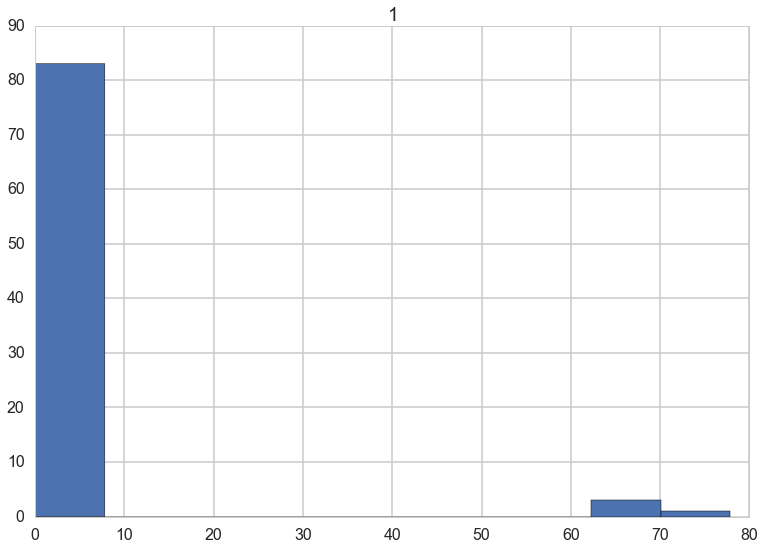

In [1904]:
#Look at distances of station for site
pd.DataFrame(best.values()).hist()

The three large values here are a city in Martinique, city in Guyana, and a city in Guadaloupe. These are again not in continental France so we'd likely want to drop them from this analysis. The others seem to have a found a weather station with data close to the urban area.

In [1909]:
#We need to store this stations in a skeleton frame
toDF = {'City':[],'FR_ID':[]}
for i,j in zip(best.keys()[1:],best.values()[1:]):
    toDF['City'].append(i)
    toDF['FR_ID'].append(j[0])
skeletonFrame = pd.DataFrame(toDF)

In [1913]:
#Drop cities that aren't in France
skeletonFrame.drop([40,49,47],axis=0,inplace=True)

In [1914]:
#Change the ID to match the file names we need to reference in a second
skeletonFrame['l_ID']=skeletonFrame['FR_ID']+'-2010'

In [1915]:
skeletonFrame.head()

,City,FR_ID,l_ID
0,Lille,070150-99999,070150-99999-2010
1,Paris,071490-99999,071490-99999-2010
2,Beziers,076415-99999,076415-99999-2010
3,Bayonne,076020-99999,076020-99999-2010
4,Roanne,073790-99999,073790-99999-2010


In [1916]:
#Import some libraries to deal with some compressed files we need to access
import urllib2
import zlib

The following code will go through files for each of the weather stations we've selected and parse the information. The files are delimited by a fixed width -- so we need to look at each block of characters and assign them to the appropriate variable. This is tedious, but fixed with is challenging to deal with smoothly.

In [1917]:
site_list = []
temp_sites = []
rh_sites = []
pressure_sites = []
wind_sites = []
for site in skeletonFrame['l_ID']:
    #Help from this post for dealing with tar.gz files
    #http://stackoverflow.com/questions/2695152/in-python-how-do-i-decode-gzip-encoding
    try:
        f=urllib2.urlopen('ftp://ftp.ncdc.noaa.gov/pub/data/noaa/2010/'+site+'.gz') 
        decompressed_data=zlib.decompress(f.read(), 16+zlib.MAX_WBITS)
        a = decompressed_data.split(';\n')
    except:
        continue
    tvar =[]
    usaf = []
    wban = []
    date = []
    gtime = []
    flag =[]
    glat = []
    glong = []
    gtype =[]
    elev = []
    call = []
    qc = []
    winddir = []
    winddir_qc = []
    wind_type = []
    windspeed = []
    windspeed_qc = []
    cheight = []
    cheight_qc = []
    cheight_det = []
    cheight_cavok = []
    visdist = []
    visdist_qc = []
    visvar = []
    visvar_qc = []
    temp = []
    temp_qc = []
    dewpoint = []
    dewpoint_qc = []
    press = []
    press_qc = []
    press2 = []
    rh = []
    rh2= []

    for row in a:
        tvar.append(row[0:4])
        usaf.append(row[4:10])
        wban.append(row[10:15])
        date.append(row[15:23])
        gtime.append(row[23:27])
        flag.append(row[27:28])
        glat.append(row[28:34])
        glong.append(row[34:41])
        gtype.append(row[41:46])
        elev.append(row[46:51])
        call.append(row[51:56])
        qc.append(row[56:60])
        winddir.append(row[60:63])
        winddir_qc.append(row[63:64])
        wind_type.append(row[64:65])
        windspeed.append(row[65:69])
        windspeed_qc.append(row[69:70])
        cheight.append(row[70:75])
        cheight_qc.append(row[75:76])
        cheight_det.append(row[76:77])
        cheight_cavok.append(row[77:78])
        visdist.append(row[78:84])
        visdist_qc.append(row[84:85])
        visvar.append(row[85:86])
        visvar_qc.append(row[86:87])
        temp.append(row[87:92])
        temp_qc.append(row[92:93])
        dewpoint.append(row[93:98])
        dewpoint_qc.append(row[98:99])
        press.append(row[99:104])
        press_qc.append(row[104:105])
        match = re.search(r'MA1[0-9]{5}.{7}',a[1])
        if match:
            press2.append(match.group()[-6:-1])
        else:
            press2.append(None)
        match = re.search(r'CH1',a[1])
        if match:
            rh.append(match.group())
        else:
            rh.append(None)
        match = re.search(r'CH2',a[1])
        if match:
            rh2.append(match.group())
        else:
            rh2.append(None)
    #Make better cleaned dataframe
    frameDict={}
    frameDict['tvar']=tvar
    frameDict["usaf"]=usaf
    frameDict['wban']=wban
    frameDict['date']=date
    frameDict['time']=gtime
    frameDict['flag']=flag
    frameDict['lat']=glat
    frameDict['long']=glong
    frameDict['type']=gtype
    frameDict['elev']=elev
    frameDict['call']=call
    frameDict['qc']=qc
    frameDict['winddir']=winddir
    frameDict['winddir_qc']=winddir_qc
    frameDict['wind_type']=wind_type
    frameDict['windspeed']=windspeed
    frameDict['windspeed_qc']=windspeed_qc
    frameDict['cheight']=cheight
    frameDict['cheight_qc']=cheight_qc
    frameDict['cheight_det']=cheight_det
    frameDict['cheight_cavok']=cheight_cavok
    frameDict['visdist']=visdist
    frameDict['visdist_qc']=visdist_qc
    frameDict['visvar']=visvar
    frameDict['visvar_qc']=visvar_qc
    frameDict['temp']=temp
    frameDict['temp_qc']=temp_qc
    frameDict['dewpoint']=dewpoint
    frameDict['dewpoint_qc']=dewpoint_qc
    frameDict['press']=press
    frameDict['press_qc']=press_qc
    frameDict['press2']=press2
    frameDict['rh']=rh
    df_stat=pd.DataFrame(frameDict)

    df_stat = df_stat.replace('99999',np.nan)
    df_stat = df_stat.replace('9999',np.nan)
    df_stat['month']=[i[4:6] for i in df_stat['date']]
    df_stat['temp'] = [(float(i)/10)*(float(9)/5)+32 if i !='' else np.nan  for i in df_stat['temp']]
    df_stat['windspeed'] = [(float(i)/10)*1.94384 if i !='' else np.nan for i in df_stat['windspeed']]
    df_stat['rh'] = [(float(i)/10) if i else np.nan for i in df_stat['rh']]
    df_stat['press'] = [(float(i)/10) if i else np.nan for i in df_stat['press']]
    meanList = df_stat.mean()
    site_list.append(site)
    temp_sites.append(meanList['temp'])
    rh_sites.append(meanList['rh'])
    pressure_sites.append(meanList['press'])
    wind_sites.append(meanList['windspeed'])

With all the weather information for each of those stations stored into one file, we can now merge this weather data with the rest of the data. We seem to be missing relative humidity for all them -- the files don't seem to have this information present. We can get this elsewhere if it turns out to be necessary, but we have the vast majority of data for france based on just this.

In [1918]:
#Make the weather frame
toFrame = {'Site':site_list,'Temp':temp_sites,'RH':rh_sites,'Pressure':pressure_sites,'Wind':wind_sites}
WeatherFrame = pd.DataFrame(toFrame)

In [1919]:
#Make a map to convert the weird numeric id to the city name
mapperWeath = {}
for i,j in zip (skeletonFrame['l_ID'],skeletonFrame['City']):
    mapperWeath[i]=j

In [1920]:
#Add city name to the weather data
WeatherFrame['city'] = WeatherFrame['Site'].map(mapperWeath.get)

In [1921]:
#Merge weather data with the previous work
FranceDat = FranceDat.merge(WeatherFrame,on='city',how='left')

In [1922]:
#Get rid of duplicate cities from merging
FranceDat = FranceDat.drop_duplicates('city')

In [1923]:
#Save the France Data
FranceDat.to_csv('FranceData.csv',index=False,na_rep='NA')

In [1924]:
FranceDat.head()

,CO,NO2,OZONE,PM10,PM25,SO2,city,id,population,popdense,area,other_frac,car_frac,pt_frac,Car,PT,Other,latitude,longitude,Pressure,RH,Site,Temp,Wind
0,0.264047,13.533663,0.022437,24.659250,17.603,0.627990,Nancy,FR30036,434479,613.363951,708.354312,0.37,0.51,0.12,221584.29,52137.48,160757.23,48.649243,6.183765,1014.182698,NaN,071800-99999-2010,49.645806,5.602288
1,0.291703,13.180851,0.025806,22.641333,16.303,0.374618,Caen,FR21001,403633,667.231583,604.936892,NaN,NaN,NaN,NaN,NaN,NaN,49.198722,-0.342557,1014.605930,NaN,070270-99999-2010,49.413654,7.613426
2,NaN,10.551064,0.022737,25.435000,NaN,0.246565,Charleville-Mezieres,FR14051,106835,334.305710,319.572764,NaN,NaN,NaN,NaN,NaN,NaN,49.745278,4.719167,1014.537853,NaN,070750-99999-2010,50.029198,4.522086
3,NaN,13.289894,0.025374,NaN,19.359,1.301908,Valence,FR36002,175636,253.757910,692.140000,NaN,NaN,NaN,NaN,NaN,NaN,44.933514,4.893481,1013.618678,NaN,075770-99999-2010,55.345660,6.962982
4,NaN,9.625000,0.028092,21.006000,NaN,NaN,Cholet,FR23078,104917,483.925584,216.803995,NaN,NaN,NaN,NaN,NaN,NaN,47.054444,-0.886111,NaN,NaN,NaN,NaN,NaN
